In [2]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.cds.internal.unity3d.com/idan-beck/simple.sensor.perception/blob/development/notebooks/autoencoder_experiment/src/Image_Autoencoder_Experiment.ipynb)

The below will simply bring in the code from the pyjunk repository and clobber the previous stuff if any in the colab

In [ ]:
# This will install pyjunk as a package
# !if [ -d pyjunk ]; then rm -Rf pyjunk; fi
# !git clone https://github.com/idanbeck/pyjunk 
# #!unzip -qq pyjunk/data/<>.zip -d pyjunk/data/
#!pip install ./repos/pyjunk

In [ ]:
import repos.pyjunk.junktools as junktools

In [1]:
# nvidia-smi is not working

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('gpu_info.find() failed with: ')
#   print(gpu_info)
# else:
#   print(gpu_info)

/bin/sh: 1: nvidia-smi: not found


In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 33.6 gigabytes of available RAM



In [ ]:
# Invoke a shell (pretty useful)

# !pip install kora
# from kora import console
# console.start()  # and click link

In [5]:
# Check for CUDA device

import torch

if(torch.cuda.is_available() == True):
    device_id = torch.cuda.current_device()
    device = torch.cuda.device(device_id)
    device_count = torch.cuda.device_count()
    device_name = torch.cuda.get_device_name(device_id)

    print("%d CUDA devices found" % device_count)
    print("Current CUDA device %d: %s" % (device_id, device_name))
else:
    print("No CUDA devices found")

1 CUDA devices found
Current CUDA device 0: NVIDIA GeForce RTX 2070 SUPER


In [ ]:
import repos.pyjunk.junktools as junktools
from repos.pyjunk.junktools import utils

train_data, test_data, train_labels, test_labels = utils.load_mnist(include_labels=True)
print(train_data.shape)
utils.visualize_data(train_data, size=200, nrow=20, nchannels=1)

In [ ]:
from repos.pyjunk.junktools import utils

# attempt to load a file

import imageio
import glob
import numpy as np

strFilepath = utils.get_data_dir('SimpleSensor_RGB_test.png')
im = np.array(imageio.imread(strFilepath))
print(im.shape)

(1080, 1920, 3)


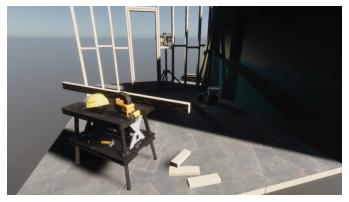

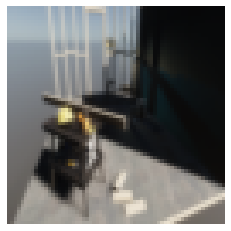

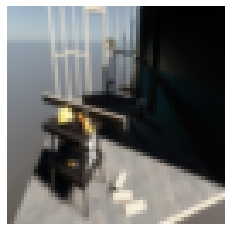

In [1]:
# Just testing out the image facilities of pyjunk

import repos.pyjunk.junktools as junktools
from repos.pyjunk.junktools.image import image

testImage = image('SimpleSensor_RGB_test.png')
print(testImage.shape())
testImage.visualize()
#testImage.print()

testImage.square(max_size=64)
testImage.visualize()
testImage.whiten(fZCA=False)
testImage.visualize()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1080, 1920, 3)
(128, 128, 3)
layer: 1 [49152:128]
layer: 2 [128:128]
layer: 3 [128:128]
layer: 4 [128:128]
layer: 5 [128:49152]
layer: 1 [49152:128]
layer: 2 [128:128]
layer: 3 [128:128]
layer: 4 [128:128]
layer: 5 [128:49152]
layer: 1 [49152:128]
layer: 2 [128:128]
layer: 3 [128:128]
layer: 4 [128:128]
layer: 5 [128:49152]
layer: 1 [49152:128]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


layer: 2 [128:128]
layer: 3 [128:128]
layer: 4 [128:128]
layer: 5 [128:49152]
Model output prior to training
torch.Size([128, 128, 3])


Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 128, 3])


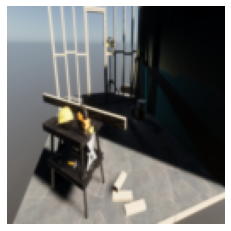

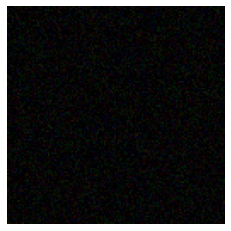

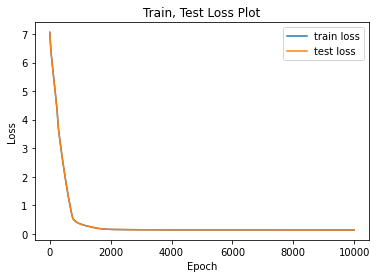

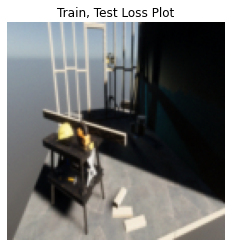

In [2]:
%load_ext autoreload
%autoreload 2

# Set up a simple MLP model

import torch

import repos.pyjunk.junktools as junktools
from repos.pyjunk.junktools.image import image
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver
from repos.pyjunk.models.SimpleMLP import SimpleMLP

import repos.pyjunk.junktools.pytorch_utils as ptu

ptu.SetGPUMode(True)

img_size = 128

# Set up our image
testImage = image('SimpleSensor_RGB_test.png')
print(testImage.shape())
testImage.square(max_size=img_size)
testImage.whiten(fZCA=False)
testImage.visualize()
print(testImage.shape())

# Set up model
H, W, C = testImage.shape()

modelMLP = SimpleMLP(
    dim_input=(H*W*C),
    dim_output=(H*W*C),
    dim_inner=min((H*W*C), 128),
    n_blocks=4,
    n_layers=4,
    fResidual=False
)

# test pass-thru (pre-train)
print("Model output prior to training")
imagePassThru = modelMLP.forward_with_image(testImage)
imagePassThru.visualize()

# Set up the solver
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 10000,
    'strOptimizer': 'Adam'
}

solver = SimpleTorchSolver(modelMLP, dictSolverParams)
solver.train_and_visualize_images([testImage], [testImage], fVerbose=True)

In [ ]:
imagePassThru = modelMLP.forward_with_image(testImage)
imagePassThru.visualize()

In [1]:
from repos.pyjunk.junktools.frame import frame
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver
from repos.pyjunk.models.SimpleMLP import SimpleMLP

strFrameID = '0001'
img_size = 128

testFrame = frame(strFrameID=strFrameID)
#print(testFrame.shape())  # TODO: this will blow up, since the sizes have not been normalized
testFrame.square(max_size=img_size)
testFrame.whiten(fZCA=False)
#testFrame.visualize()
print(testFrame.shape())

testFrameRGB = frame(sourceFrame=testFrame, sourceChannels=['rgb'])
testFrameCond = frame(
    sourceFrame=testFrame, 
    sourceChannels=[
        'albedo', 
        'ambient_occlusion',
        'depth',
        'normal',
        'object_id',
        'smooth',
        'specular',
        'uv'
    ])

# Split into target and conditional buffers
testFrameRGB.visualize(strTitle="testFrameRGB")
testFrameCond.visualize(strTitle="testFrameCond")

# # Set up model
H_frame, W_frame, C_frame = testFrameCond.shape()
H_rgb, W_rgb, C_rgb = testFrameRGB.shape()

modelMLP = SimpleMLP(
    dim_input=(H_frame*W_frame*C_frame),
    dim_output=(H_rgb*W_rgb*C_rgb),
    dim_inner=min((H_rgb*W_rgb*C_rgb), 128),
    n_blocks=4,
    n_layers=4,
    fResidual=False
)

print("input dims: %d, %d, %d" % (H_frame, W_frame, C_frame))

# test pass-thru (pre-train)
print("Model output prior to training")
imagePassThru = modelMLP.forward_with_frame(testFrameCond)
imagePassThru.visualize(strTitle="imagePassThru pre-train")

# Set up the solver
dictSolverParams = {
    'lr': 1e-3,
    'epochs': 100,
    'strOptimizer': 'Adam'
}

# Note: Single image so likely that last layers are just memorizing the output honestly :) 
# Train on test frame conditional buffers and RGB target 
solver = SimpleTorchSolver(modelMLP, dictSolverParams)
solver.train_and_visualize_frames(
    [(testFrameCond, testFrameRGB)], 
    [(testFrameCond, testFrameRGB)])

FileNotFoundError: [Errno 2] No such file or directory: 'repos/pyjunk/data/frames/0001'

In [1]:
%load_ext autoreload
%autoreload 2

# Try to set up training on a set of frames, eval on frames the model has not seen

from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver
from repos.pyjunk.models.SimpleMLP import SimpleMLP

strFramesetName = 'spheres'
img_size = 32
batch_size = 10
test_batch_size = 2
num_frames = 640

spheres = frameset(strFramesetName, num_frames=num_frames, fJITLoading=True, fVerbose=False)
spheres.square(max_size=img_size)
spheres.whiten(fZCA=False)
spheres.Print()
#spheres.visualize()
#spheres.save_to_disk('spheres_32_white')

# Play a sound when done
print('\a')

print(spheres.shape())


Loading frames 2 to 642
Frameset: spheres, 640 frames with 10 channels JIT enabled

(640, 32, 32, 30)


In [2]:
from repos.pyjunk.junktools.frameset import frameset

# Split up into Conditional and RGB Target framesets
spheresRGB = frameset(sourceFrameset=spheres, strNewFramesetName="spheresRGB", sourceChannels=['rgb'])
spheresRGB.Print()

spheresCond = frameset(
    sourceFrameset=spheres, 
    strNewFramesetName="spheresCond",
    sourceChannels=[
        'albedo', 
        'ambientocclusion',
        'depth',
        'normal',
        'objectid',
        'smoothness',
        'specular',
        'uv'
    ])
spheresCond.Print()

#spheresCond.visualize()
#spheresRGB.visualize()

# Shape of a single frame
testnpbuf = spheresCond[0].GetNumpyBuffer()
print(testnpbuf.shape)

print(spheres.shape())
print(spheresCond.shape())


Frameset: spheresRGB, 640 frames with 1 channels JIT enabled
Frameset: spheresCond, 640 frames with 8 channels JIT enabled
(32, 32, 24)
(640, 32, 32, 30)
(640, 32, 32, 24)


visualizing image state: states.not_loaded id: 2 frameset: spheres
loading image state: states.loading channel: albedo id: 2 frameset: spheres
squaring image state: states.loading channel: albedo id: 2 frameset: spheres
whitening image state: states.loading channel: albedo id: 2 frameset: spheres
loaded image state: states.loaded channel: albedo id: 2 frameset: spheres
unloaded image state: states.not_loaded channel: albedo id: 2 frameset: spheres
visualizing image state: states.not_loaded id: 2 frameset: spheres
loading image state: states.loading channel: ambientocclusion id: 2 frameset: spheres
squaring image state: states.loading channel: ambientocclusion id: 2 frameset: spheres
whitening image state: states.loading channel: ambientocclusion id: 2 frameset: spheres
loaded image state: states.loaded channel: ambientocclusion id: 2 frameset: spheres
unloaded image state: states.not_loaded channel: ambientocclusion id: 2 frameset: spheres
visualizing image state: states.not_loaded id:

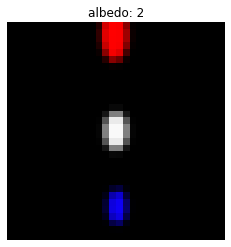

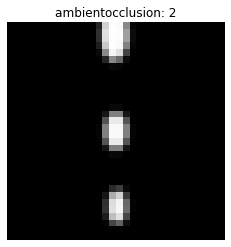

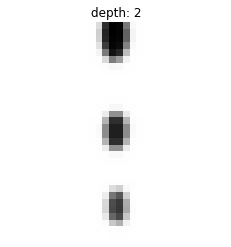

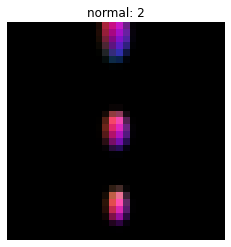

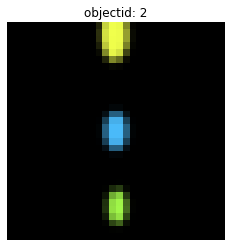

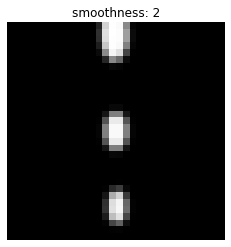

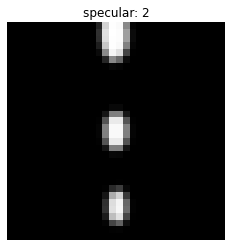

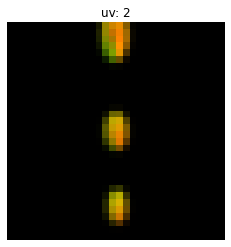

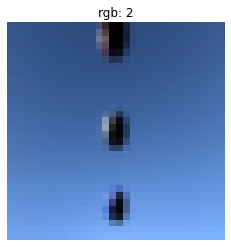

In [7]:
spheresCond[0].visualize()
spheresRGB[0].visualize()

(640, 32, 32, 24)
(640, 32, 32, 3)
layer: 1 [24576:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072]
layer: 5 [3072:3072]
layer: 6 [3072:3072]
layer: 1 [3072:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072]
layer: 5 [3072:3072]
layer: 6 [3072:3072]
layer: 1 [3072:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072]
layer: 5 [3072:3072]
layer: 6 [3072:3072]
layer: 1 [3072:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072]
layer: 5 [3072:3072]
layer: 6 [3072:3072]
layer: 1 [3072:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072]
layer: 5 [3072:3072]
layer: 6 [3072:3072]
layer: 1 [3072:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072]
layer: 5 [3072:3072]
layer: 6 [3072:3072]
layer: 1 [3072:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072]
layer: 5 [3072:3072]
layer: 6 [3072:3072]
layer: 1 [3072:3072]
layer: 2 [3072:3072]
layer: 3 [3072:3072]
layer: 4 [3072:3072

Epoch 41, Test loss 0.2410
training on frames [83, 425, 420, 390, 212, 614, 203, 220, 343, 169] in frameset spheresCond
testing on frames [550, 334] in frameset spheresCond
Epoch 42, Test loss 0.2972
training on frames [358, 10, 450, 112, 401, 325, 228, 62, 22, 613] in frameset spheresCond
testing on frames [601, 315] in frameset spheresCond
Epoch 43, Test loss 0.3109
training on frames [519, 311, 418, 578, 117, 394, 184, 485, 390, 332] in frameset spheresCond
testing on frames [221, 189] in frameset spheresCond
Epoch 44, Test loss 0.3112
training on frames [61, 371, 273, 56, 489, 469, 202, 124, 248, 340] in frameset spheresCond
testing on frames [275, 108] in frameset spheresCond
Epoch 45, Test loss 0.3144
training on frames [589, 537, 219, 555, 448, 136, 233, 336, 610, 44] in frameset spheresCond
testing on frames [442, 557] in frameset spheresCond
Epoch 46, Test loss 0.2801
training on frames [541, 61, 343, 84, 0, 623, 209, 97, 475, 509] in frameset spheresCond
testing on frames [21

testing on frames [321, 181] in frameset spheresCond
Epoch 89, Test loss 0.2803
training on frames [78, 417, 571, 303, 623, 493, 247, 361, 109, 388] in frameset spheresCond
testing on frames [252, 66] in frameset spheresCond
Epoch 90, Test loss 0.3069
training on frames [63, 246, 258, 552, 584, 29, 170, 162, 223, 123] in frameset spheresCond
testing on frames [22, 476] in frameset spheresCond
Epoch 91, Test loss 0.3609
training on frames [281, 264, 479, 270, 528, 487, 21, 464, 267, 149] in frameset spheresCond
testing on frames [436, 253] in frameset spheresCond
Epoch 92, Test loss 0.3178
training on frames [238, 204, 54, 304, 600, 523, 443, 201, 500, 326] in frameset spheresCond
testing on frames [353, 144] in frameset spheresCond
Epoch 93, Test loss 0.3962
training on frames [30, 378, 159, 394, 479, 362, 311, 13, 414, 576] in frameset spheresCond
testing on frames [288, 168] in frameset spheresCond
Epoch 94, Test loss 0.3976
training on frames [63, 588, 512, 331, 208, 133, 453, 339, 

testing on frames [613, 108] in frameset spheresCond
Epoch 137, Test loss 0.3455
training on frames [323, 537, 79, 162, 484, 135, 444, 577, 333, 3] in frameset spheresCond
testing on frames [639, 359] in frameset spheresCond
Epoch 138, Test loss 0.3065
training on frames [262, 328, 546, 639, 351, 339, 505, 586, 329, 117] in frameset spheresCond
testing on frames [551, 426] in frameset spheresCond
Epoch 139, Test loss 0.3494
training on frames [396, 3, 435, 335, 253, 596, 311, 126, 544, 344] in frameset spheresCond
testing on frames [55, 617] in frameset spheresCond
Epoch 140, Test loss 0.2579
training on frames [419, 403, 259, 357, 255, 218, 621, 369, 152, 79] in frameset spheresCond
testing on frames [469, 639] in frameset spheresCond
Epoch 141, Test loss 0.2569
training on frames [364, 287, 440, 208, 175, 389, 25, 5, 83, 306] in frameset spheresCond
testing on frames [456, 160] in frameset spheresCond
Epoch 142, Test loss 0.3124
training on frames [390, 41, 315, 587, 563, 337, 387, 7

testing on frames [193, 305] in frameset spheresCond
Epoch 185, Test loss 0.3585
training on frames [66, 515, 358, 318, 77, 259, 534, 78, 124, 231] in frameset spheresCond
testing on frames [333, 45] in frameset spheresCond
Epoch 186, Test loss 0.3638
training on frames [392, 209, 317, 453, 249, 29, 114, 443, 386, 20] in frameset spheresCond
testing on frames [247, 142] in frameset spheresCond
Epoch 187, Test loss 0.3307
training on frames [166, 248, 434, 344, 475, 441, 238, 63, 444, 30] in frameset spheresCond
testing on frames [143, 446] in frameset spheresCond
Epoch 188, Test loss 0.3133
training on frames [169, 549, 142, 434, 167, 206, 462, 172, 72, 178] in frameset spheresCond
testing on frames [589, 623] in frameset spheresCond
Epoch 189, Test loss 0.2892
training on frames [215, 94, 222, 455, 90, 390, 530, 171, 372, 142] in frameset spheresCond
testing on frames [31, 28] in frameset spheresCond
Epoch 190, Test loss 0.3576
training on frames [588, 185, 411, 293, 176, 443, 552, 38

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


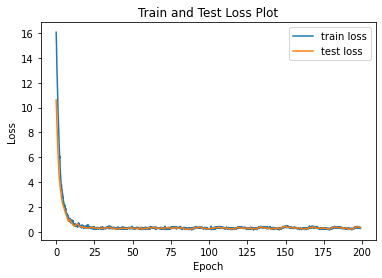

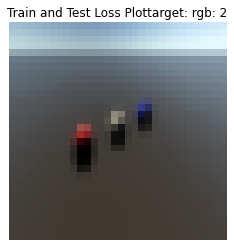

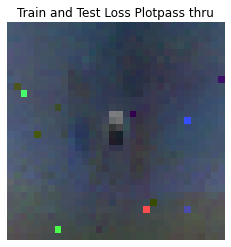

In [3]:
from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SimpleMLP import SimpleMLP
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver

# Set up model
num_frames, H_frames, W_frames, C_frames = spheresCond.shape()
num_rgb, H_rgb, W_rgb, C_rgb = spheresRGB.shape()

print(spheresCond.shape())
print(spheresRGB.shape())

modelMLP = SimpleMLP(
    dim_input=(H_frames*W_frames*C_frames),
    dim_output=(H_rgb*W_rgb*C_rgb),
    #dim_inner=min((H_rgb*W_rgb*C_rgb), 512),
    dim_inner=(H_rgb*W_rgb*C_rgb),
    n_blocks=8,
    n_layers=5,
    fResidual=True
)

print("input dims: %d, %d, %d" % (H_frames, W_frames, C_frames))

# Test pass-thru with a frameset
# Shape of a frameset
#testnpbufset = spheresCond.GetNumpyBuffer()
#print(testnpbufset.shape)
# images = modelMLP.forward_with_frameset(spheresCond)
# print(len(images))
# images[0].visualize(strTitle="imagePassThru pre-train")

# Set up the solver
dictSolverParams = {
    'lr': 5e-4,
    'epochs': 200,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size
}

# # Train on frameset (no minibatching yet)
solver = SimpleTorchSolver(modelMLP, dictSolverParams)
solver.train_and_visualize_frameset(
    train_source_frameset=spheresCond, train_target_frameset=spheresRGB, 
    test_source_frameset=spheresCond, test_target_frameset=spheresRGB, 
    fVerbose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


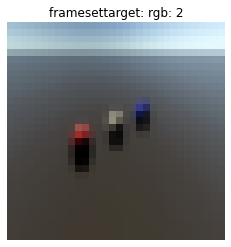

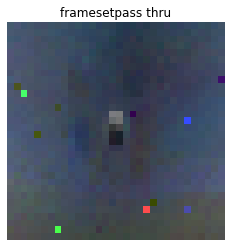

In [4]:
solver.visualize_frameset(test_source_frameset=spheresCond, test_target_frameset=spheresRGB)

In [5]:
# Test pass-thru with a frameset
# Shape of a frameset
#testnpbufset = spheresCond.GetNumpyBuffer()
#print(testnpbufset.shape)
images = modelMLP.forward_with_frameset(spheresCond)
print(len(images))

640


In [1]:
i = 20
spheresRGB[i].visualize()
images[i].visualize(strTitle="imagePassThru post-train")

NameError: name 'spheresRGB' is not defined

In [1]:
%load_ext autoreload
%autoreload 2

# Get the Convnet Based Model working (dataset)

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SimpleResnet import SimpleResnet
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver

strFramesetName = 'spheres'
img_size = 32
batch_size = 10
test_batch_size = 2
num_frames = 640

spheres = frameset(strFramesetName, num_frames=num_frames, fJITLoading=True, fVerbose=False)
spheres.square(max_size=img_size)
spheres.whiten(fZCA=False)
spheres.Print()
#spheres.visualize()
#spheres.save_to_disk('spheres_32_white')

# Play a sound when done
print('\a')

print(spheres.shape())

# Split up into Conditional and RGB Target framesets
spheresRGB = frameset(sourceFrameset=spheres, strNewFramesetName="spheresRGB", sourceChannels=['rgb'])
spheresRGB.Print()

spheresCond = frameset(
    sourceFrameset=spheres, 
    strNewFramesetName="spheresCond",
    sourceChannels=[
        'albedo', 
        'ambientocclusion',
        'depth',
        'normal',
        'objectid',
        'smoothness',
        'specular',
        'uv'
    ])
spheresCond.Print()

#spheresCond.visualize()
#spheresRGB.visualize()

# Shape of a single frame
testnpbuf = spheresCond[0].GetNumpyBuffer()
print(testnpbuf.shape)

print(spheres.shape())
print(spheresCond.shape())

Loading frames 2 to 642
Frameset: spheres, 640 frames with 10 channels JIT enabled

(640, 32, 32, 30)
Frameset: spheresRGB, 640 frames with 1 channels JIT enabled
Frameset: spheresCond, 640 frames with 8 channels JIT enabled
(32, 32, 24)
(640, 32, 32, 30)
(640, 32, 32, 24)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
input dims: 32, 32, 24
output dims: 32, 32, 3
in:24 out:3 channels
training on frames [398, 583, 6, 269, 434, 190, 541, 31, 594, 610] in frameset spheresCond
testing on frames [218, 493] in frameset spheresCond
Epoch 0, Test loss 4.0963
training on frames [27, 170, 525, 419, 190, 96, 421, 534, 179, 274] in frameset spheresCond
testing on frames [203, 404] in frameset spheresCond
Epoch 1, Test loss 3.9843
training on frames [518, 382, 362, 392, 112, 118, 30, 1, 440, 116] in frameset spheresCond
testing on frames [410, 600] in frameset spheresCond
Epoch 2, Test loss 3.8180
training on frames [554, 258, 359, 356, 629, 418, 72, 129, 94, 449] in frameset spheresCond
testing on frames [545, 410] in frameset spheresCond
Epoch 3, Test loss 3.6373
training on frames [545, 622, 388, 128, 80, 350, 429, 352, 33, 176] in frameset spheresCond
testing on frames [390, 468] in frameset spheresCond
Epoch 4, Test loss

Epoch 46, Test loss 1.2717
training on frames [528, 590, 215, 85, 311, 207, 316, 501, 378, 195] in frameset spheresCond
testing on frames [260, 290] in frameset spheresCond
Epoch 47, Test loss 1.2228
training on frames [169, 527, 496, 190, 28, 581, 589, 594, 414, 387] in frameset spheresCond
testing on frames [549, 320] in frameset spheresCond
Epoch 48, Test loss 1.1768
training on frames [133, 16, 125, 117, 425, 343, 59, 634, 312, 427] in frameset spheresCond
testing on frames [195, 530] in frameset spheresCond
Epoch 49, Test loss 1.1809
training on frames [627, 70, 84, 384, 625, 351, 363, 436, 600, 26] in frameset spheresCond
testing on frames [289, 313] in frameset spheresCond
Epoch 50, Test loss 1.0990
training on frames [506, 315, 434, 71, 158, 155, 557, 342, 161, 273] in frameset spheresCond
testing on frames [90, 293] in frameset spheresCond
Epoch 51, Test loss 1.0410
training on frames [620, 307, 226, 536, 567, 493, 321, 119, 243, 408] in frameset spheresCond
testing on frames 

testing on frames [619, 293] in frameset spheresCond
Epoch 94, Test loss 0.3456
training on frames [187, 245, 567, 544, 538, 406, 461, 231, 111, 354] in frameset spheresCond
testing on frames [571, 583] in frameset spheresCond
Epoch 95, Test loss 0.4475
training on frames [36, 616, 485, 21, 508, 343, 338, 6, 464, 361] in frameset spheresCond
testing on frames [207, 335] in frameset spheresCond
Epoch 96, Test loss 0.4132
training on frames [352, 409, 564, 75, 310, 546, 76, 110, 215, 154] in frameset spheresCond
testing on frames [274, 289] in frameset spheresCond
Epoch 97, Test loss 0.3678
training on frames [386, 450, 34, 162, 445, 264, 561, 444, 632, 43] in frameset spheresCond
testing on frames [633, 130] in frameset spheresCond
Epoch 98, Test loss 0.4228
training on frames [208, 492, 180, 35, 4, 431, 565, 555, 68, 448] in frameset spheresCond
testing on frames [492, 394] in frameset spheresCond
Epoch 99, Test loss 0.3808


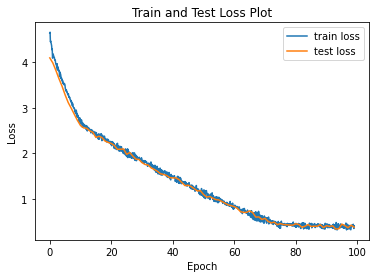

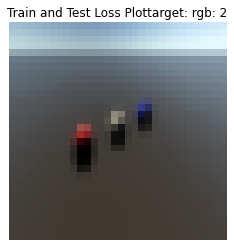

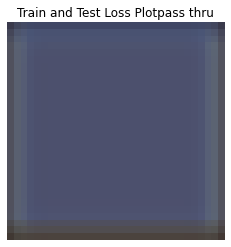

In [2]:
%load_ext autoreload
%autoreload 2

# Get the Convnet Based Model working

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SimpleResnet import SimpleResnet
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver

# Set up model
num_frames, H_frames, W_frames, C_frames = spheresCond.shape()
num_rgb, H_rgb, W_rgb, C_rgb = spheresRGB.shape()

print("input dims: %d, %d, %d" % (H_frames, W_frames, C_frames))
print("output dims: %d, %d, %d" % (H_rgb, W_rgb, C_rgb))

modelResnet = SimpleResnet(
    input_shape=(H_frames, W_frames, C_frames),
    output_shape=(H_rgb, W_rgb, C_rgb),
    n_blocks=5,
    n_layers=8,
    n_filters=128,
    fResidual=True
)

# Test pass-thru with a frameset
# Shape of a frameset
# testnpbufset = spheresCond.GetNumpyBuffer()
# print(testnpbufset.shape)

# images = modelResnet.forward_with_frameset(spheresCond)
# print(len(images))
# images[0].visualize(strTitle="imagePassThru pre-train")

# Set up the solver
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 100,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size
}

# Train on frameset (no minibatching yet)
solver = SimpleTorchSolver(modelResnet, dictSolverParams)
solver.train_and_visualize_frameset(
    train_source_frameset=spheresCond, train_target_frameset=spheresRGB, 
    test_source_frameset=spheresCond, test_target_frameset=spheresRGB, 
    fVerbose=True)

In [5]:
%load_ext autoreload
%autoreload 2

# Pre-process the frameset (32px, 64px, 128px, 256px, 512px)

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SimpleResnet import SimpleResnet
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver

import time

strFramesetName = 'reflective_primitives_1024'

#img_sizes = [64, 256, 512]
img_sizes = [64]
batch_size = 128
test_batch_size = 20
#num_frames = 3620
num_frames = 10

start_time = time.time()
spheres = frameset(strFramesetName, num_frames=num_frames, fJITLoading=True, fVerbose=True)
end_time = time.time()

spheresCond = frameset(
    sourceFrameset=spheres, 
    strNewFramesetName="spheresCond",
    sourceChannels=[
        "Albedo",
        "Ambient Occlusion",
        "Color",
        "Position",
#        "Depth",
#        "Metal",
#        "Motion",
        "Normal",
        "Object Id",
#        "Smoothness",
#        "Specular",
        "UV",
      ])

time_per_frame = ((end_time - start_time)/num_frames) 
fps = 1./time_per_frame
print("loaded %s frames JIT at %s seconds/frame that's %s frames per second" % (num_frames, time_per_frame, fps))

start_time = time.time()
for img_size in img_sizes:
    strNewFramesetName = 'reflective_primitives_%s' % img_size
    spheresCond.clear_transforms()
    spheresCond.square(max_size=img_size)
    spheresCond.whiten(fZCA=False)
    spheresCond.Print()
    
    print("Saving %s dataset" % strNewFramesetName)
    spheres.save_to_new_frameset(strNewFramesetName)

end_time = time.time()
time_per_frame = (end_time - start_time)/(num_frames * len(img_sizes)) 
fps = 1./time_per_frame
print("saved %s frames JIT at %s seconds/frame that's %s frames per second" % (num_frames, time_per_frame, fps))

# Play a sound when done
print('\a')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading frames 5 to 15
Loading: frame 5
Loading: frame 6
Loading: frame 7
Loading: frame 8
Loading: frame 9
Loading: frame 10
Loading: frame 11
Loading: frame 12
Loading: frame 13
Loading: frame 14
loaded 10 frames JIT at 0.013569068908691407 seconds/frame that's 73.69702421950774 frames per second
Frameset: spheresCond, 10 frames with 7 channels JIT enabled
Saving reflective_primitives_64 dataset
repos/pyjunk/data/frames/reflective_primitives_64/reflective_primitives_64.json
Saving frames 5 to 15
loading image state: states.loading channel: albedo id: 5 frameset: reflective_primitives_1024 path: repos/pyjunk/data/frames/reflective_primitives_1024/5/Albedo.Png
squaring image state: states.loading channel: albedo id: 5 frameset: reflective_primitives_1024
whitening image state: states.loading channel: albedo id: 5 frameset: reflective_primitives_1024
loaded image state: states.loaded channel: albedo 

ValueError: Could not load "" 
Reason: "broken data stream when reading image file"
Please see documentation at: http://pillow.readthedocs.io/en/latest/installation.html#external-libraries

In [2]:
%load_ext autoreload
%autoreload 2

# Pre-process the frameset (32px, 64px, 128px, 256px, 512px)

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SimpleResnet import SimpleResnet
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.SimpleTorchSolver import SimpleTorchSolver

import time

strFramesetName = 'primitives'

img_sizes = [16, 32, 64, 128, 256, 512]
batch_size = 128
test_batch_size = 20
num_frames = 5000

start_time = time.time()
spheres = frameset(strFramesetName, num_frames=num_frames, fJITLoading=True, fVerbose=False)
end_time = time.time()

time_per_frame = ((end_time - start_time)/num_frames) 
fps = 1./time_per_frame
print("loaded %s frames JIT at %s seconds/frame that's %s frames per second" % (num_frames, time_per_frame, fps))

start_time = time.time()
for img_size in img_sizes:
    strNewFramesetName = 'primitives_%s' % img_size
    spheres.clear_transforms()
    spheres.square(max_size=img_size)
    spheres.whiten(fZCA=False)
    spheres.Print()
    
    print("Saving %s dataset" % strNewFramesetName)
    spheres.save_to_new_frameset(strNewFramesetName)

end_time = time.time()
time_per_frame = (end_time - start_time)/(num_frames * len(img_sizes)) 
fps = 1./time_per_frame
print("saved %s frames JIT at %s seconds/frame that's %s frames per second" % (num_frames, time_per_frame, fps))

# Play a sound when done
print('\a')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading frames 1 to 5000


KeyboardInterrupt: 

In [2]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

strFramesetName = 'primitives'
strNewFramesetName = 'primitives_64_wht'
img_size = 32
batch_size = 128
test_batch_size = 20
num_frames = 4900

primitives = frameset(
    strNewFramesetName, 
    num_frames=num_frames, 
    fJITLoading=True, 
    fVerbose=False
)
primitives.Print()
print(primitives.shape())

# Split up into Conditional and RGB Target framesets
primitivesRGB = frameset(
    sourceFrameset=primitives, 
    strNewFramesetName="primitivesRGB", 
    sourceChannels=['Color']
)

primitivesRGB.Print()
#primitivesRGB[0].visualize()

primitivesCond = frameset(
    sourceFrameset=primitives, 
    strNewFramesetName="primitivesCond",
    sourceChannels=[
        "Albedo",
        "Ambient Occlusion",
#        "Color",
        "Depth",
#        "Metal",
#        "Motion",
        "Normal",
        "Object Id",
        "Smoothness",
        "Specular",
        "UV",
      ])
primitivesCond.Print()
#primitivesCond[0].visualize()

# #spheresCond.visualize()
# #spheresRGB.visualize()

# Shape of a single frame
testnpbuf = primitivesCond[0].GetNumpyBuffer()
print(testnpbuf.shape)

print(primitives.shape())
print(primitivesCond.shape())
print(primitivesRGB.shape())

# split spheresRGB into spheresRGB_train, speheresRGB_test

primitivesRGB_train, primitivesRGB_test = primitivesRGB.split_into_train_and_test(0.8)
print(primitivesRGB_train.shape())
print(primitivesRGB_test.shape())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading frames 1 to 4901
Frameset: primitives_64_wht, 4900 frames with 11 channels JIT enabled
(4900, 64, 64, 33)
Frameset: primitivesRGB, 4900 frames with 1 channels JIT enabled
Frameset: primitivesCond, 4900 frames with 8 channels JIT enabled
(64, 64, 24)
(4900, 64, 64, 33)
(4900, 64, 64, 24)
(4900, 64, 64, 3)
(3920, 64, 64, 3)
(980, 64, 64, 3)


In [6]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

# Conv VAE
# Only learns the distribution of the target RGB images
# This network doesn't need anything outside of the target images and is entirely unsupervised 

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.ConvVAE import ConvVAE
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.ConvVAETorchSolver import ConvVAETorchSolver

# Set up model
num_rgb, H_rgb, W_rgb, C_rgb = primitivesRGB.shape()
#latent_dim = 16
latent_dim = 5
batch_size = 128
test_batch_size = 20

#print("input dims: %d, %d, %d" % (H_frames, W_frames, C_frames))
print("target dims: %d, %d, %d" % (H_rgb, W_rgb, C_rgb))

modelConvVAE = ConvVAE(
    input_shape=(H_rgb, W_rgb, C_rgb),
    latent_dim=latent_dim
)

# Test model
# npFrameBuffer = spheresRGB_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0)
# print(torchImageBuffer.shape)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# modelConvVAE.encoder.forward(torchImageBuffer)

# loss = modelConvVAE.loss_with_frame(spheresRGB_train[0])
# print(loss)

# Set up the solver
dictSolverParams = {
    'lr': 3e-4,
    'epochs': 1000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size
}

# Train on frameset (no minibatching yet)
solver = ConvVAETorchSolver(modelConvVAE, dictSolverParams)
solver.train_frameset_and_plot_losses(
    train_frameset=primitivesRGB_train, 
    test_frameset=primitivesRGB_test,
    fVerbose=True)

# Sample the network
sampleImages = modelConvVAE.sample(10)
sampleImages[0].visualize()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
target dims: 64, 64, 3
3
training on frames [3012, 3773, 795, 3864, 2786, 224, 2508, 684, 1349, 1027, 1564, 1911, 1994, 2917, 3563, 2643, 2744, 2099, 3142, 2158, 3008, 62, 1843, 3474, 468, 3733, 1477, 811, 2433, 1444, 813, 2170, 529, 3419, 1156, 2648, 2470, 683, 1453, 2400, 1256, 454, 3040, 3239, 268, 1369, 2473, 2220, 922, 1841, 3825, 2996, 2584, 1104, 2376, 2932, 3287, 576, 4, 2283, 2339, 2575, 825, 1170, 3254, 3845, 3014, 1286, 1830, 99, 2562, 1219, 3883, 3173, 1188, 3817, 3449, 3508, 3374, 3515, 1252, 2617, 2621, 2189, 3153, 3462, 338, 3850, 2821, 90, 2199, 1714, 1740, 3676, 2771, 1922, 1637, 2519, 184, 2720, 1240, 2286, 382, 2392, 2865, 3059, 1295, 1373, 2347, 2806, 2718, 1634, 886, 1650, 1402, 1749, 652, 3205, 2440, 2042, 3775, 3396, 1143, 3223, 2972, 285, 1631, 3535] in frameset primitivesRGB_train
testing on frames [300, 237, 490, 259, 688, 266, 178, 562, 820, 284, 848, 543, 32, 571, 157, 42

testing on frames [710, 271, 923, 104, 97, 749, 672, 784, 195, 393, 7, 111, 647, 541, 967, 383, 337, 177, 51, 701] in frameset primitivesRGB_test
Epoch 8, Test loss 16.3758
training on frames [3233, 342, 417, 44, 2345, 2597, 3850, 2002, 3532, 165, 1696, 3714, 130, 3901, 2195, 1793, 3360, 3883, 1138, 2112, 3199, 2286, 1400, 929, 1972, 262, 695, 2219, 181, 2555, 3007, 2983, 771, 2482, 2606, 3683, 3458, 972, 3358, 309, 3624, 3434, 1, 51, 3317, 666, 806, 420, 3193, 2734, 2458, 1461, 3731, 823, 3403, 1777, 292, 2238, 1105, 363, 2622, 198, 1706, 1401, 2660, 1708, 1507, 2648, 2165, 1680, 176, 3896, 965, 3603, 376, 927, 304, 2096, 45, 677, 210, 1468, 438, 3479, 1801, 1766, 3373, 3132, 2215, 733, 860, 3, 3790, 3461, 2220, 1406, 3364, 1407, 1518, 298, 1992, 2669, 630, 1241, 2989, 2316, 1824, 3309, 1707, 208, 1289, 3112, 1057, 2875, 2958, 1512, 2959, 1352, 2182, 1534, 3055, 3431, 2602, 2070, 2635, 1927, 347, 2680] in frameset primitivesRGB_train
testing on frames [711, 756, 154, 197, 152, 191, 36

testing on frames [62, 35, 848, 486, 483, 72, 965, 57, 938, 175, 400, 375, 824, 233, 449, 732, 642, 758, 860, 333] in frameset primitivesRGB_test
Epoch 17, Test loss 16.5082
training on frames [1948, 3516, 1295, 2817, 67, 264, 507, 1776, 1994, 2162, 2917, 2750, 3563, 1009, 3909, 3756, 1434, 1387, 593, 1510, 1826, 2326, 3565, 584, 2518, 3286, 2159, 3302, 1938, 694, 2169, 1359, 2896, 3570, 1815, 3767, 430, 2685, 3207, 500, 2857, 2781, 3530, 2, 3044, 1392, 341, 2870, 3247, 788, 3177, 96, 2888, 87, 914, 1112, 219, 2045, 2273, 2224, 502, 3140, 1075, 2956, 1338, 105, 3292, 1589, 1793, 1445, 2749, 2034, 2722, 3800, 1876, 3762, 3787, 1149, 375, 1939, 2697, 323, 2508, 269, 2094, 186, 3455, 2969, 3523, 2073, 965, 1086, 1231, 2584, 2706, 2055, 1087, 750, 262, 3751, 579, 627, 1060, 1832, 2053, 1848, 2582, 2738, 249, 1398, 2043, 1687, 2051, 126, 967, 1518, 2207, 3572, 3450, 2953, 3701, 1283, 2882, 3915, 3683, 1779, 421, 2613] in frameset primitivesRGB_train
testing on frames [453, 914, 283, 734, 61

testing on frames [544, 608, 915, 31, 178, 603, 520, 719, 907, 774, 43, 259, 747, 665, 563, 29, 207, 637, 286, 488] in frameset primitivesRGB_test
Epoch 26, Test loss 13.0313
training on frames [2578, 2728, 3130, 1977, 2203, 3778, 899, 732, 1594, 3383, 765, 3704, 3472, 1342, 3126, 2798, 302, 2587, 2159, 3624, 1818, 1382, 1328, 1798, 3106, 3895, 2437, 2577, 1778, 183, 2928, 2813, 2767, 505, 1763, 1773, 1947, 1367, 3469, 2927, 590, 571, 330, 97, 940, 3157, 2651, 3323, 1914, 2448, 2276, 3791, 753, 1956, 262, 1754, 3886, 3531, 3848, 2507, 3319, 3510, 1283, 449, 3024, 3907, 1527, 1805, 33, 1411, 891, 446, 1826, 2895, 2716, 1154, 2305, 1227, 422, 3405, 1612, 1116, 3170, 1626, 3537, 937, 2012, 1518, 1391, 3019, 1506, 1375, 1002, 2348, 1524, 3906, 2621, 425, 1472, 127, 3917, 889, 3566, 3630, 1540, 452, 2288, 1436, 3488, 2491, 2682, 798, 3502, 581, 465, 1791, 3827, 882, 2641, 3577, 1864, 2814, 2541, 2782, 2089, 2046, 560, 936] in frameset primitivesRGB_train
testing on frames [237, 261, 318, 87

testing on frames [71, 55, 88, 798, 226, 625, 127, 174, 248, 663, 960, 500, 260, 99, 310, 793, 92, 602, 766, 923] in frameset primitivesRGB_test
Epoch 35, Test loss 13.6092
training on frames [3498, 3528, 3222, 1673, 1550, 2411, 682, 858, 3577, 1028, 2914, 3279, 3805, 763, 2526, 180, 681, 3792, 877, 1436, 3562, 129, 311, 1430, 1822, 735, 2286, 3416, 805, 431, 466, 821, 546, 3744, 2167, 1165, 2381, 3736, 2396, 3111, 152, 241, 3628, 1312, 1789, 1008, 879, 3690, 3483, 920, 203, 3431, 411, 2374, 639, 2223, 1683, 556, 234, 2831, 475, 1575, 1626, 1495, 518, 509, 2151, 2687, 2500, 2078, 1599, 3214, 1148, 2080, 3195, 3760, 533, 224, 2723, 2534, 674, 1306, 3309, 3323, 1401, 3688, 3839, 1950, 1207, 151, 2127, 3907, 2851, 1628, 710, 747, 3667, 1582, 2152, 1903, 2983, 3617, 1804, 1469, 3159, 545, 1649, 3262, 1691, 3207, 783, 2981, 67, 3891, 104, 2969, 967, 1365, 1024, 308, 950, 2751, 2903, 1866, 438, 2183, 2790, 3914] in frameset primitivesRGB_train
testing on frames [22, 25, 316, 751, 857, 99, 29

testing on frames [425, 809, 10, 620, 20, 498, 5, 341, 330, 390, 467, 802, 586, 286, 281, 377, 541, 722, 721, 45] in frameset primitivesRGB_test
Epoch 44, Test loss 13.8984
training on frames [2595, 1091, 2874, 1782, 1826, 2854, 773, 2556, 3080, 223, 1607, 557, 510, 417, 3127, 365, 3249, 2658, 3379, 3715, 3486, 2589, 241, 1946, 2462, 504, 594, 2386, 3425, 1214, 230, 1737, 2240, 635, 3063, 2704, 2723, 426, 1416, 1312, 20, 3514, 3596, 1554, 705, 1315, 528, 2819, 913, 2885, 2009, 2545, 3877, 581, 3168, 3237, 2361, 3055, 181, 2540, 3558, 2373, 608, 1346, 1991, 908, 1319, 826, 2163, 3595, 2908, 3805, 931, 769, 538, 3178, 1115, 2639, 103, 555, 3271, 3056, 2147, 3673, 323, 3286, 1644, 1997, 2866, 1509, 3912, 2246, 3235, 266, 1143, 2254, 1974, 2579, 2631, 156, 681, 1719, 795, 3608, 3174, 3866, 1618, 89, 1686, 1629, 992, 3393, 3797, 2443, 1260, 2270, 522, 1771, 1558, 2182, 68, 873, 2629, 2633, 2244, 3255, 1553, 1337] in frameset primitivesRGB_train
testing on frames [97, 586, 452, 833, 691, 428

testing on frames [247, 572, 508, 765, 3, 191, 535, 41, 636, 354, 162, 317, 772, 802, 128, 579, 357, 815, 71, 595] in frameset primitivesRGB_test
Epoch 53, Test loss 12.0888
training on frames [2128, 3457, 2015, 2492, 1234, 2631, 3294, 1045, 1364, 3906, 2001, 2255, 319, 1385, 2550, 2699, 2071, 606, 2560, 3151, 3378, 454, 3386, 1828, 1366, 2118, 1872, 1555, 2532, 885, 1290, 2008, 3865, 3729, 1584, 1008, 737, 1410, 2724, 679, 2766, 2795, 1574, 1895, 3077, 2334, 3811, 212, 1978, 2067, 2342, 1231, 3782, 2310, 3712, 1799, 2649, 1326, 114, 3738, 2942, 1609, 3705, 1347, 2070, 2273, 3017, 762, 3144, 504, 868, 2367, 2401, 146, 3684, 2174, 216, 676, 1718, 2681, 1340, 871, 1934, 1726, 913, 1422, 2019, 586, 3326, 150, 345, 3558, 393, 2106, 314, 2409, 838, 951, 589, 2684, 2202, 1330, 3771, 448, 2691, 1260, 1306, 145, 1296, 3276, 329, 2346, 832, 1953, 3328, 1622, 2529, 1242, 1068, 685, 1561, 1955, 3703, 2460, 1362, 122, 1428, 1792] in frameset primitivesRGB_train
testing on frames [495, 76, 468, 847

testing on frames [310, 943, 373, 150, 544, 591, 151, 111, 941, 803, 2, 716, 503, 671, 745, 412, 786, 970, 665, 191] in frameset primitivesRGB_test
Epoch 62, Test loss 12.8636
training on frames [2711, 3058, 138, 609, 2324, 1029, 3537, 2056, 2966, 274, 640, 3040, 1778, 268, 165, 2347, 1155, 2886, 3482, 1421, 1040, 2449, 3569, 1366, 1733, 875, 3355, 1947, 3709, 3036, 2758, 106, 1852, 3115, 338, 3713, 1623, 2709, 118, 3829, 3273, 2924, 1001, 2994, 1628, 912, 1742, 2985, 3335, 3029, 3331, 3320, 3489, 3019, 2162, 174, 2853, 1422, 3072, 2089, 3008, 892, 1423, 2845, 1811, 2953, 7, 3456, 988, 1476, 1957, 3810, 3431, 51, 1061, 2857, 1177, 2692, 1166, 3752, 2549, 3712, 1552, 86, 1018, 1326, 996, 2297, 3157, 1459, 1669, 594, 3021, 2969, 3706, 3096, 3480, 3917, 1592, 2062, 2432, 770, 3412, 2283, 1157, 1969, 979, 2191, 167, 3855, 821, 2125, 1701, 542, 2479, 2070, 2628, 2607, 2745, 2059, 1853, 1815, 1289, 2055, 3011, 2296, 466, 290] in frameset primitivesRGB_train
testing on frames [718, 38, 13, 59

testing on frames [241, 710, 539, 571, 291, 530, 837, 480, 339, 670, 82, 1, 891, 695, 205, 328, 782, 170, 885, 67] in frameset primitivesRGB_test
Epoch 71, Test loss 13.0112
training on frames [1202, 743, 1285, 2639, 3234, 805, 43, 831, 1777, 3747, 145, 1233, 168, 2830, 2424, 537, 1991, 673, 1161, 1230, 2030, 3787, 3449, 1985, 125, 1021, 640, 193, 2319, 3793, 1409, 1705, 2995, 2533, 2206, 2945, 2820, 1891, 3733, 1708, 2819, 834, 1806, 3390, 2332, 3231, 2107, 2067, 3713, 507, 1139, 2053, 2103, 2541, 3489, 226, 2488, 3622, 5, 1391, 2291, 1856, 784, 2445, 186, 2415, 3736, 115, 687, 3395, 2585, 3699, 948, 3542, 674, 3573, 524, 1577, 2283, 2734, 665, 3116, 2944, 419, 3402, 2064, 3673, 2966, 3261, 300, 2501, 3314, 1310, 1601, 806, 3792, 141, 2485, 3720, 552, 3252, 91, 474, 2540, 3686, 3854, 2175, 1878, 317, 1525, 2429, 479, 1010, 924, 1630, 3591, 2781, 2733, 3198, 3447, 143, 1857, 1455, 1392, 2337, 2659, 3349, 1196] in frameset primitivesRGB_train
testing on frames [950, 639, 534, 853, 252, 

testing on frames [218, 437, 592, 263, 690, 562, 270, 488, 714, 187, 6, 175, 100, 7, 15, 145, 104, 134, 280, 67] in frameset primitivesRGB_test
Epoch 80, Test loss 11.9089
training on frames [108, 720, 241, 118, 387, 2556, 3856, 3890, 2045, 3076, 3477, 596, 2271, 1812, 982, 3393, 789, 2374, 1650, 2516, 2722, 851, 3062, 760, 3264, 1604, 3083, 2482, 1797, 556, 2437, 566, 3852, 327, 570, 428, 1072, 2745, 1074, 1333, 2708, 2172, 1418, 994, 199, 1274, 2769, 2520, 2421, 584, 3075, 1018, 1854, 3844, 1739, 1105, 2793, 3519, 868, 2966, 2114, 3416, 2517, 2664, 1506, 2072, 2436, 2179, 781, 1992, 2736, 3873, 3316, 528, 1651, 2153, 2825, 263, 1585, 571, 2390, 2453, 2428, 1749, 1246, 2519, 806, 1413, 2902, 3235, 239, 7, 631, 1311, 3082, 342, 1878, 2290, 3626, 1612, 1068, 2242, 1386, 136, 1536, 3094, 1408, 2949, 1880, 2278, 3336, 3791, 106, 3840, 741, 2730, 3717, 1231, 70, 790, 2806, 1332, 3781, 746, 3850, 1825, 1655, 552] in frameset primitivesRGB_train
testing on frames [215, 602, 895, 943, 82, 539

testing on frames [964, 462, 133, 53, 742, 399, 506, 950, 698, 581, 510, 561, 201, 860, 289, 629, 582, 435, 828, 875] in frameset primitivesRGB_test
Epoch 89, Test loss 11.1903
training on frames [297, 1668, 1413, 659, 527, 2038, 1538, 2307, 2140, 2426, 3346, 1503, 1523, 1452, 3106, 3114, 2366, 3665, 3007, 2187, 3897, 1118, 336, 3327, 961, 1584, 895, 1697, 174, 3035, 1688, 2179, 2098, 1119, 2421, 3094, 2368, 592, 1596, 1146, 2442, 1847, 480, 1976, 3840, 1215, 585, 1314, 2706, 3311, 3497, 3514, 3700, 609, 3276, 784, 2402, 1881, 917, 50, 3582, 2702, 455, 1765, 820, 3755, 279, 3430, 3016, 716, 429, 1760, 2639, 2282, 1698, 2058, 1578, 2911, 2326, 248, 3258, 751, 2419, 902, 438, 1507, 1408, 147, 1619, 3577, 2800, 3448, 1113, 3816, 515, 2370, 1903, 518, 2582, 1575, 2613, 3077, 2384, 1433, 6, 1700, 1187, 762, 2492, 1546, 1394, 90, 637, 918, 306, 3640, 2455, 1768, 2373, 1128, 640, 2133, 2731, 2233, 968, 3148, 77, 2790] in frameset primitivesRGB_train
testing on frames [957, 203, 241, 924, 1, 7

testing on frames [526, 504, 670, 274, 95, 301, 874, 294, 446, 142, 562, 42, 617, 418, 831, 880, 543, 945, 545, 828] in frameset primitivesRGB_test
Epoch 98, Test loss 11.0461
training on frames [2764, 3100, 286, 2027, 3608, 3069, 3182, 2095, 3823, 1769, 2240, 634, 624, 2457, 2570, 415, 3600, 2822, 1490, 659, 736, 2456, 1229, 1695, 2682, 1035, 1562, 1943, 430, 3547, 2006, 2110, 320, 965, 2644, 2507, 2553, 916, 758, 2187, 3379, 168, 83, 3409, 1825, 3862, 3412, 2561, 1126, 956, 389, 3605, 3709, 2579, 3133, 1041, 2780, 2591, 2272, 2249, 296, 3758, 907, 265, 1613, 3204, 2696, 1323, 1169, 2947, 3328, 1285, 3705, 2753, 1193, 2209, 139, 2795, 1130, 2273, 1667, 557, 3619, 2783, 1725, 3652, 444, 1837, 3529, 1854, 2317, 2823, 2874, 2079, 2008, 106, 3109, 3494, 1248, 2746, 3112, 1158, 347, 1739, 2154, 750, 3718, 852, 2015, 250, 3221, 902, 2169, 2211, 2937, 3894, 159, 1672, 3806, 2283, 3761, 2291, 1443, 381, 2308, 1744, 416, 120] in frameset primitivesRGB_train
testing on frames [399, 26, 645, 276

testing on frames [371, 947, 242, 832, 174, 717, 712, 235, 164, 737, 977, 327, 561, 706, 670, 277, 507, 756, 620, 966] in frameset primitivesRGB_test
Epoch 107, Test loss 13.6579
training on frames [3261, 228, 1595, 699, 2862, 2183, 329, 332, 593, 254, 443, 3788, 1625, 3570, 479, 1903, 1939, 3009, 626, 415, 2028, 3029, 2821, 37, 3038, 2984, 283, 3061, 1645, 2725, 1095, 3138, 1260, 524, 3390, 1123, 3312, 1062, 3526, 2103, 1724, 2980, 571, 91, 3612, 661, 3400, 1504, 3087, 1670, 1915, 325, 3196, 3027, 2582, 126, 1979, 1462, 335, 2041, 3666, 2583, 2620, 111, 2044, 1834, 3674, 1291, 3758, 2367, 2830, 3005, 505, 932, 212, 2622, 3799, 2322, 1708, 2380, 2095, 3730, 2797, 1452, 213, 3901, 2274, 2966, 3856, 1700, 3262, 3141, 251, 33, 862, 46, 416, 2368, 3353, 3538, 3394, 3537, 694, 2848, 163, 434, 3232, 2955, 3605, 809, 2808, 205, 1118, 3414, 2391, 1054, 514, 399, 1244, 1042, 3912, 3589, 3429, 13, 1737, 1184, 420, 2325] in frameset primitivesRGB_train
testing on frames [325, 962, 571, 783, 477, 

testing on frames [547, 613, 349, 488, 52, 850, 355, 353, 851, 435, 1, 641, 220, 117, 302, 874, 415, 282, 366, 191] in frameset primitivesRGB_test
Epoch 116, Test loss 11.8346
training on frames [1097, 2711, 1028, 80, 1608, 973, 464, 3670, 1753, 225, 1773, 3515, 305, 3716, 763, 2319, 3597, 1077, 3270, 2912, 3660, 3204, 1672, 252, 3750, 1778, 3480, 149, 1777, 2174, 2664, 1559, 1417, 3260, 2905, 1409, 204, 2297, 1981, 1694, 1046, 522, 1370, 3531, 2242, 3815, 1927, 1719, 3573, 3277, 3324, 2119, 2932, 1374, 1952, 2748, 158, 3620, 550, 2959, 31, 748, 1654, 2702, 1520, 1102, 163, 1354, 1246, 1086, 1891, 1564, 2497, 3519, 580, 3511, 2473, 1296, 889, 1665, 900, 2935, 3646, 3162, 1683, 2107, 651, 3899, 2331, 1255, 3658, 607, 2287, 2509, 1461, 3314, 1143, 2432, 1812, 1817, 935, 2411, 233, 3278, 1458, 3296, 3197, 3560, 3185, 1286, 872, 3136, 3226, 1112, 2348, 304, 2850, 2206, 2973, 2732, 29, 1958, 2535, 1892, 203, 3534, 1289, 3069] in frameset primitivesRGB_train
testing on frames [64, 51, 166, 7

testing on frames [399, 728, 450, 134, 251, 187, 210, 265, 184, 721, 672, 139, 585, 209, 954, 395, 834, 557, 494, 926] in frameset primitivesRGB_test
Epoch 125, Test loss 11.3563
training on frames [327, 3507, 3846, 3762, 735, 504, 2633, 1262, 388, 3129, 3611, 2024, 1845, 2511, 1460, 1360, 112, 1247, 2231, 431, 3255, 3789, 998, 2394, 1270, 106, 1715, 1316, 199, 2565, 1502, 1427, 2987, 2170, 1263, 3484, 173, 3108, 894, 2050, 1208, 3304, 3732, 2765, 3435, 775, 351, 152, 1473, 2598, 2549, 2047, 3003, 1913, 1239, 2275, 3089, 1165, 2413, 3677, 572, 2357, 390, 876, 679, 859, 3519, 2558, 543, 1676, 1571, 2428, 2380, 923, 839, 1452, 2923, 647, 2267, 3859, 1202, 2943, 1462, 545, 3263, 3588, 116, 3687, 92, 2130, 2924, 883, 2614, 2978, 3220, 1562, 828, 1006, 368, 2479, 66, 1948, 922, 2762, 1822, 3830, 2898, 2434, 3002, 1258, 2080, 615, 3047, 2832, 2780, 816, 525, 3781, 340, 2373, 797, 3521, 846, 686, 271, 1955, 1224, 1722] in frameset primitivesRGB_train
testing on frames [637, 264, 45, 512, 108,

testing on frames [787, 512, 235, 19, 378, 435, 55, 926, 170, 427, 952, 928, 869, 805, 510, 594, 391, 801, 460, 698] in frameset primitivesRGB_test
Epoch 134, Test loss 11.6571
training on frames [3753, 27, 44, 2691, 2501, 473, 382, 2719, 890, 3123, 3561, 2035, 2756, 3011, 3047, 948, 2506, 1453, 2594, 1669, 1402, 2733, 3872, 2755, 3790, 945, 290, 64, 392, 1510, 1999, 2544, 2952, 378, 789, 445, 108, 574, 976, 1150, 3523, 1915, 2657, 3614, 1919, 2603, 1765, 759, 2821, 2933, 889, 2656, 107, 1982, 2117, 2638, 3630, 404, 2446, 2214, 430, 1166, 3742, 123, 2067, 308, 743, 730, 2494, 1648, 1024, 2975, 1725, 1748, 773, 3334, 1436, 1416, 1284, 273, 3859, 1824, 3542, 1504, 569, 2295, 3538, 85, 3064, 3212, 2221, 2021, 2579, 483, 2263, 3055, 3417, 1476, 2407, 3263, 2487, 3082, 1880, 729, 875, 2161, 1917, 1008, 1253, 2770, 2983, 3188, 1509, 1878, 1061, 1890, 1217, 2033, 2328, 3414, 3446, 88, 2008, 2080, 2717, 3901, 3460, 502] in frameset primitivesRGB_train
testing on frames [389, 863, 289, 287, 577

testing on frames [603, 979, 802, 170, 518, 175, 840, 116, 838, 812, 910, 89, 92, 776, 339, 382, 327, 974, 791, 237] in frameset primitivesRGB_test
Epoch 143, Test loss 11.0490
training on frames [2475, 1440, 1812, 2619, 1744, 3547, 2777, 349, 3570, 2804, 385, 670, 21, 1728, 1183, 512, 461, 2086, 549, 3380, 181, 2014, 2928, 3828, 828, 509, 1627, 3157, 1000, 1080, 1633, 3041, 2149, 345, 3245, 2611, 728, 3459, 3698, 2375, 1305, 1643, 1431, 2136, 1284, 2000, 975, 629, 3400, 1030, 1217, 2472, 689, 641, 2921, 1066, 1275, 1687, 1137, 941, 327, 1765, 3464, 2864, 2806, 3173, 3397, 447, 3741, 3087, 3175, 1732, 1363, 1182, 3220, 1981, 490, 1154, 3632, 3563, 2812, 3304, 311, 2159, 1460, 159, 648, 2810, 1382, 368, 3912, 3072, 773, 2403, 426, 2799, 2625, 45, 2207, 477, 959, 414, 3174, 141, 1365, 3615, 2836, 3354, 1242, 2349, 2170, 888, 3, 2737, 3431, 2336, 3602, 703, 2688, 1917, 3880, 1083, 2315, 3201, 350, 819, 3199, 2073] in frameset primitivesRGB_train
testing on frames [193, 696, 243, 673, 286,

testing on frames [225, 341, 644, 108, 577, 186, 126, 806, 160, 608, 535, 712, 194, 580, 824, 54, 138, 958, 436, 867] in frameset primitivesRGB_test
Epoch 152, Test loss 11.4356
training on frames [2960, 827, 3523, 2521, 3513, 2314, 2220, 3303, 2594, 3746, 531, 3912, 3260, 101, 3847, 2425, 3560, 1405, 860, 1568, 2534, 545, 3382, 1255, 244, 1777, 224, 242, 1843, 1518, 477, 3888, 2958, 1464, 1111, 3376, 121, 540, 3416, 332, 3266, 2222, 3381, 3087, 588, 1492, 3155, 595, 2774, 362, 3681, 3028, 2363, 977, 759, 750, 1059, 1280, 3358, 2451, 2786, 203, 2755, 939, 3334, 888, 3181, 2186, 2468, 2496, 2784, 1648, 2200, 204, 1196, 3142, 2848, 3133, 2360, 1469, 1561, 1851, 2870, 1066, 3060, 3837, 680, 471, 1733, 149, 3772, 2940, 2396, 1433, 2188, 140, 3353, 2865, 2787, 591, 3809, 3401, 3330, 2252, 1024, 3426, 3601, 2991, 318, 1330, 368, 469, 108, 3197, 3611, 2626, 3537, 3629, 821, 2628, 805, 936, 1473, 2778, 2824, 981, 2366, 1160] in frameset primitivesRGB_train
testing on frames [327, 477, 555, 386

testing on frames [420, 2, 703, 947, 930, 351, 145, 860, 688, 498, 749, 178, 808, 946, 719, 489, 357, 695, 398, 497] in frameset primitivesRGB_test
Epoch 161, Test loss 11.1014
training on frames [1761, 3583, 1117, 3866, 907, 3533, 1784, 3822, 953, 2540, 3915, 3268, 1322, 2954, 1378, 2891, 1678, 3234, 511, 916, 1580, 2083, 1143, 1816, 3478, 2075, 162, 971, 1214, 2848, 992, 3857, 1032, 1334, 2342, 456, 2165, 3691, 2339, 1828, 342, 2431, 2272, 2990, 1349, 3083, 2429, 219, 288, 2297, 2909, 773, 1596, 1531, 2651, 733, 3019, 2280, 1045, 1156, 3704, 963, 373, 1738, 2467, 934, 1745, 2598, 3831, 2109, 2128, 2286, 1965, 2989, 1973, 3265, 2384, 183, 703, 2880, 2935, 929, 1044, 1107, 2634, 2310, 1639, 2330, 1539, 3406, 1656, 689, 2003, 1675, 3742, 2804, 1890, 2877, 3284, 2924, 3105, 273, 2538, 3428, 3837, 2748, 3322, 3836, 3688, 3218, 656, 1649, 1938, 2898, 3335, 2017, 2006, 429, 2667, 1469, 1904, 2323, 869, 2078, 697, 2359, 324, 5] in frameset primitivesRGB_train
testing on frames [46, 175, 424,

testing on frames [449, 690, 427, 37, 823, 644, 938, 847, 591, 103, 946, 947, 892, 33, 911, 966, 128, 702, 95, 319] in frameset primitivesRGB_test
Epoch 170, Test loss 10.3436
training on frames [3194, 3571, 3027, 3130, 427, 1503, 1700, 3413, 847, 1078, 1231, 2821, 1915, 1292, 820, 178, 3853, 3347, 2417, 3213, 3648, 1413, 1939, 2893, 1631, 2183, 3467, 557, 1477, 136, 700, 1433, 3791, 2277, 2760, 3616, 2631, 393, 2961, 1964, 2831, 3314, 3816, 1609, 3442, 2255, 1023, 1120, 1395, 164, 2348, 1247, 3122, 3858, 1602, 2918, 3345, 3781, 3894, 2237, 122, 3035, 3541, 278, 1417, 1225, 789, 581, 1265, 1101, 1262, 3273, 3326, 3227, 2284, 989, 3507, 2427, 1729, 2832, 2858, 561, 3330, 2932, 2878, 1504, 3615, 3723, 1932, 1560, 1911, 2365, 211, 3555, 2360, 1731, 1143, 400, 3537, 1931, 3706, 2701, 3901, 2732, 1865, 3565, 117, 3408, 2909, 1878, 1198, 2115, 3277, 551, 3646, 2976, 3770, 2496, 3223, 441, 792, 3759, 3914, 401, 3344, 693, 2415, 470] in frameset primitivesRGB_train
testing on frames [848, 793,

testing on frames [845, 186, 904, 128, 334, 650, 426, 29, 661, 303, 253, 38, 542, 245, 227, 13, 976, 49, 582, 451] in frameset primitivesRGB_test
Epoch 179, Test loss 10.8560
training on frames [2487, 876, 1102, 3259, 3362, 47, 266, 2740, 1876, 1864, 2350, 150, 82, 3314, 1467, 3677, 2914, 1974, 62, 133, 1054, 1278, 1954, 3771, 1302, 1052, 846, 2289, 1072, 2354, 3462, 315, 1002, 939, 1735, 1803, 2599, 2915, 1167, 508, 1935, 1919, 3861, 1227, 1236, 1444, 239, 42, 1489, 3495, 2009, 2615, 264, 3393, 1546, 2148, 3010, 820, 3628, 349, 372, 27, 967, 2567, 655, 579, 1038, 1663, 3230, 1235, 2186, 1373, 3629, 2142, 2416, 3775, 1256, 2372, 3653, 1823, 3379, 2634, 3511, 1058, 78, 2343, 1398, 3085, 3492, 1649, 2851, 709, 3089, 1892, 114, 93, 3280, 3198, 2016, 3826, 3432, 3121, 3697, 1287, 564, 25, 1641, 265, 2445, 144, 596, 2920, 1182, 1937, 344, 2997, 1448, 218, 3590, 1595, 2147, 2220, 127, 3725, 296, 3605, 2419, 2049] in frameset primitivesRGB_train
testing on frames [556, 868, 765, 664, 420, 87,

testing on frames [515, 240, 373, 18, 155, 562, 843, 956, 863, 438, 349, 861, 842, 85, 715, 477, 352, 775, 893, 412] in frameset primitivesRGB_test
Epoch 188, Test loss 11.7040
training on frames [3063, 1896, 2367, 2151, 2981, 3, 589, 1054, 2197, 3627, 3404, 3251, 2372, 2441, 429, 1759, 3516, 2861, 2152, 1287, 578, 1904, 2023, 57, 1158, 3068, 1377, 87, 1999, 2921, 1897, 3760, 3298, 3606, 2723, 268, 1685, 2296, 356, 2885, 1100, 2131, 2624, 1471, 3445, 21, 1216, 257, 1214, 3170, 3091, 3126, 905, 1423, 2834, 1864, 972, 193, 3531, 764, 3429, 2289, 1863, 3737, 3479, 3472, 3358, 1881, 3705, 1989, 3326, 1573, 1751, 353, 1188, 921, 1359, 904, 1621, 1211, 2447, 63, 3308, 3594, 3545, 1079, 1720, 1507, 1092, 3757, 1739, 982, 3836, 1310, 7, 1304, 3119, 328, 54, 3371, 263, 669, 1547, 949, 1298, 453, 1539, 757, 261, 644, 1910, 2389, 3480, 104, 2387, 2831, 1498, 2356, 643, 1383, 46, 3059, 1179, 2235, 302, 1742, 2350, 702] in frameset primitivesRGB_train
testing on frames [358, 195, 761, 975, 53, 493,

testing on frames [678, 552, 472, 49, 576, 765, 862, 370, 91, 745, 781, 87, 323, 331, 865, 816, 148, 956, 656, 556] in frameset primitivesRGB_test
Epoch 197, Test loss 12.8160
training on frames [2802, 3017, 3739, 3593, 2121, 1911, 1486, 3489, 3229, 1908, 1952, 3759, 272, 293, 3114, 3274, 1627, 1023, 1537, 559, 904, 3908, 3510, 1543, 705, 3212, 1305, 1384, 2645, 1005, 4, 2213, 3097, 2569, 1898, 3911, 857, 1814, 3257, 1929, 2023, 2465, 1338, 1967, 2555, 1008, 644, 3642, 2758, 594, 598, 2818, 109, 826, 1097, 3504, 369, 1710, 119, 1369, 486, 2112, 581, 1143, 3207, 184, 900, 3253, 3839, 2689, 432, 88, 3301, 2973, 1579, 2192, 3289, 2444, 2718, 2837, 3505, 358, 2577, 3211, 3245, 2287, 3747, 285, 3359, 3178, 3898, 2015, 3442, 15, 3729, 638, 707, 1265, 619, 842, 146, 1451, 1314, 2078, 3705, 346, 3352, 255, 2898, 1394, 1808, 2616, 1977, 3737, 3841, 141, 3473, 1539, 2933, 2598, 3694, 2998, 77, 2229, 1860, 493, 1022, 2565] in frameset primitivesRGB_train
testing on frames [697, 475, 266, 437, 144

testing on frames [368, 129, 719, 66, 660, 462, 81, 806, 476, 305, 873, 55, 656, 25, 868, 581, 351, 943, 104, 169] in frameset primitivesRGB_test
Epoch 206, Test loss 10.9082
training on frames [2621, 3673, 1056, 1796, 584, 2206, 3800, 1637, 2408, 1491, 627, 1475, 3848, 91, 751, 3601, 2681, 3110, 2759, 3443, 2093, 3786, 3579, 3460, 1741, 607, 793, 3203, 3196, 2320, 2749, 3269, 3765, 160, 3545, 3480, 1315, 2680, 1084, 1464, 889, 1559, 1693, 744, 391, 1858, 2879, 3462, 2694, 766, 1891, 3437, 3234, 1351, 3119, 2399, 2827, 1885, 1791, 2994, 1764, 390, 2564, 585, 572, 1430, 157, 2565, 2162, 371, 987, 3250, 3224, 1472, 3839, 2014, 3694, 1634, 195, 1754, 3083, 521, 3907, 2177, 765, 855, 1148, 90, 1032, 3599, 2182, 3890, 1120, 1382, 955, 529, 2204, 3199, 3654, 2128, 31, 1474, 2723, 1505, 3384, 3291, 3383, 1306, 1103, 2853, 2652, 33, 1316, 1298, 895, 262, 3864, 2260, 2442, 3074, 3750, 2069, 351, 1271, 3540, 2381, 3536, 1649] in frameset primitivesRGB_train
testing on frames [264, 92, 271, 454, 

testing on frames [522, 130, 970, 877, 370, 73, 292, 640, 948, 141, 820, 375, 748, 960, 957, 565, 690, 450, 826, 767] in frameset primitivesRGB_test
Epoch 215, Test loss 11.1203
training on frames [2286, 1686, 1881, 2235, 656, 3139, 3474, 3707, 945, 3806, 3106, 797, 3552, 1352, 3307, 1675, 2951, 2218, 2938, 920, 657, 3863, 1556, 1573, 403, 947, 866, 298, 3395, 1045, 11, 2240, 3381, 3413, 1631, 3180, 2402, 3444, 1635, 3831, 454, 2533, 1142, 2731, 1282, 2343, 1313, 863, 2611, 1388, 170, 2552, 201, 2189, 1394, 1380, 864, 3769, 316, 2076, 2879, 88, 1445, 252, 1708, 1930, 2146, 1278, 2640, 1961, 2021, 1806, 2174, 1418, 2338, 814, 1003, 2466, 2285, 2470, 3168, 1860, 3693, 3492, 2998, 2094, 989, 1766, 3262, 1923, 1592, 1971, 3104, 2845, 787, 2013, 2799, 793, 59, 1799, 730, 716, 2624, 2284, 437, 3225, 1566, 294, 2700, 3580, 1087, 3144, 187, 2195, 435, 556, 1697, 3629, 3646, 2032, 497, 2253, 2096, 2988, 929, 1601, 1670, 1279] in frameset primitivesRGB_train
testing on frames [955, 127, 209, 27,

testing on frames [1, 83, 523, 888, 487, 750, 112, 641, 383, 447, 718, 185, 913, 218, 435, 70, 501, 844, 381, 283] in frameset primitivesRGB_test
Epoch 224, Test loss 10.0605
training on frames [2394, 1817, 2589, 3420, 3204, 619, 2869, 2507, 1772, 1109, 3315, 3615, 1212, 2306, 3864, 1317, 1950, 2743, 559, 1598, 1541, 2728, 3587, 3691, 2366, 2806, 2527, 1123, 3531, 180, 86, 2117, 1419, 57, 966, 2410, 1135, 1969, 2755, 2987, 130, 1185, 5, 799, 919, 1506, 1703, 1616, 1409, 2730, 520, 3491, 2516, 1769, 1929, 1480, 3104, 2153, 1390, 1835, 1924, 1229, 2833, 2066, 1058, 3450, 1223, 490, 1559, 1234, 281, 1378, 1403, 3158, 3209, 1731, 1373, 1779, 1778, 780, 8, 356, 2268, 3321, 2067, 2422, 846, 1395, 2317, 1583, 3522, 3121, 1400, 827, 2805, 3263, 887, 1674, 2071, 2713, 523, 469, 3630, 913, 1190, 256, 2257, 894, 3806, 2050, 3000, 844, 3071, 3427, 3764, 3311, 2008, 1460, 3018, 2412, 1159, 3068, 3513, 437, 2515, 3674, 3910, 1725] in frameset primitivesRGB_train
testing on frames [754, 199, 312, 57,

testing on frames [475, 235, 531, 739, 727, 260, 27, 839, 222, 268, 199, 391, 200, 100, 698, 616, 726, 797, 948, 244] in frameset primitivesRGB_test
Epoch 233, Test loss 10.5476
training on frames [1891, 2780, 3347, 3013, 2931, 1890, 2334, 1663, 3359, 1574, 245, 17, 1062, 535, 2547, 3472, 3365, 2390, 2157, 2306, 3132, 2135, 3693, 2615, 1739, 2249, 3051, 1597, 365, 3047, 2626, 401, 762, 250, 544, 3576, 2981, 58, 2682, 2003, 2397, 2406, 2373, 3456, 3575, 104, 3631, 1180, 2984, 3666, 54, 3769, 1676, 1602, 3435, 234, 3296, 166, 2260, 508, 3776, 3053, 2077, 969, 3039, 2799, 2683, 41, 3751, 1523, 2542, 2238, 3540, 3150, 765, 764, 1754, 3184, 712, 2696, 1256, 695, 2565, 155, 1946, 3583, 412, 1054, 2141, 2986, 1995, 2468, 293, 45, 3064, 1703, 2127, 1599, 3563, 2317, 2737, 2392, 175, 1342, 989, 835, 1421, 2310, 1802, 3792, 2273, 402, 2728, 2908, 1280, 2758, 291, 1435, 1237, 1127, 2484, 2400, 899, 1815, 3737, 2264, 1997, 3103] in frameset primitivesRGB_train
testing on frames [808, 787, 594, 773

testing on frames [570, 139, 225, 487, 510, 5, 440, 59, 647, 780, 56, 566, 880, 385, 215, 771, 777, 241, 296, 675] in frameset primitivesRGB_test
Epoch 242, Test loss 10.6314
training on frames [3169, 2707, 261, 1627, 1666, 2119, 1899, 972, 239, 480, 2766, 1729, 1080, 513, 1176, 1102, 1032, 951, 2381, 420, 705, 249, 67, 2048, 1826, 2626, 427, 3186, 78, 926, 948, 2538, 1549, 549, 2193, 2296, 1103, 572, 3907, 2666, 687, 849, 3910, 38, 1984, 3116, 248, 122, 505, 1485, 3885, 2723, 3463, 3539, 2791, 475, 3037, 118, 2440, 3874, 2094, 90, 1797, 1429, 886, 1077, 3032, 2126, 1233, 550, 405, 3502, 2224, 351, 1134, 3038, 2680, 2422, 1873, 3224, 3458, 2161, 686, 1970, 1700, 1840, 546, 3671, 2016, 1922, 3301, 3205, 921, 1167, 3330, 539, 3203, 2501, 685, 652, 985, 154, 1348, 3074, 3043, 3452, 2596, 346, 3075, 72, 1672, 9, 2121, 876, 110, 642, 1950, 2466, 3358, 2042, 3688, 2994, 3792, 2810, 1750, 1016, 2031, 761] in frameset primitivesRGB_train
testing on frames [48, 451, 78, 179, 795, 204, 198, 170,

testing on frames [764, 261, 7, 264, 21, 461, 192, 117, 370, 955, 792, 563, 731, 493, 795, 232, 669, 42, 170, 160] in frameset primitivesRGB_test
Epoch 251, Test loss 10.4500
training on frames [2754, 2341, 3279, 1036, 2412, 1449, 3654, 3056, 1765, 1434, 3760, 313, 1286, 87, 1878, 2541, 609, 135, 1576, 2547, 571, 3384, 1591, 3832, 322, 2661, 2774, 3808, 2257, 2789, 669, 529, 1791, 3897, 879, 2276, 1572, 3088, 466, 2960, 2226, 1159, 3462, 2099, 3705, 3454, 1666, 3525, 254, 8, 2336, 995, 136, 2517, 2202, 649, 3467, 2351, 2824, 477, 1655, 1087, 518, 2783, 153, 3673, 3465, 1844, 1612, 644, 10, 707, 2449, 1605, 1808, 3563, 2825, 1094, 2069, 2076, 2429, 1165, 1538, 1843, 1523, 374, 3574, 2201, 720, 3740, 2568, 3652, 3770, 421, 904, 1299, 937, 1720, 1018, 1248, 2458, 1391, 3380, 3416, 2869, 642, 3022, 2154, 2885, 2721, 3742, 2971, 965, 3719, 3548, 1420, 1924, 1357, 2443, 3841, 2326, 3583, 1786, 3611, 1002, 1990, 3689, 2679] in frameset primitivesRGB_train
testing on frames [740, 736, 974, 206

testing on frames [794, 117, 582, 829, 126, 973, 889, 98, 521, 338, 861, 753, 643, 780, 884, 505, 716, 927, 518, 412] in frameset primitivesRGB_test
Epoch 260, Test loss 10.9517
training on frames [1441, 2050, 3019, 2212, 3114, 2865, 788, 2708, 3278, 2488, 1420, 271, 12, 3674, 2844, 2151, 753, 162, 3156, 1769, 1722, 1724, 3078, 3335, 3781, 2990, 2622, 1808, 3012, 2338, 474, 701, 29, 3742, 2307, 2850, 3631, 2716, 2557, 3137, 1428, 795, 810, 2181, 652, 2509, 3603, 2103, 3600, 3246, 2069, 1969, 1363, 1615, 1372, 646, 616, 871, 1829, 1931, 237, 43, 622, 1251, 3127, 2590, 2249, 3624, 1380, 2091, 2668, 2453, 2876, 1113, 2082, 623, 2547, 2962, 2229, 428, 612, 2575, 930, 1349, 1177, 1048, 482, 731, 584, 2240, 3547, 3615, 1691, 500, 1907, 1804, 1998, 1450, 1353, 2823, 1120, 1510, 2368, 2191, 454, 1688, 2574, 3349, 2367, 2381, 563, 2935, 759, 1150, 3730, 899, 566, 423, 2806, 1110, 3482, 2655, 3604, 383, 2918, 459, 700, 1090] in frameset primitivesRGB_train
testing on frames [273, 628, 783, 751, 

testing on frames [414, 207, 367, 144, 741, 220, 228, 732, 313, 174, 742, 731, 567, 523, 648, 380, 211, 582, 691, 903] in frameset primitivesRGB_test
Epoch 269, Test loss 10.6129
training on frames [3197, 1484, 513, 1806, 604, 2251, 2305, 3225, 3671, 2966, 2690, 2167, 706, 1790, 884, 1810, 1569, 1879, 2965, 618, 2991, 217, 2338, 448, 1359, 2588, 2867, 3501, 3182, 3018, 3143, 1922, 3506, 3742, 92, 2289, 3741, 2718, 1285, 1136, 2715, 3062, 1202, 2924, 612, 1900, 1710, 1865, 3177, 2801, 1257, 726, 239, 2385, 1726, 161, 2030, 2541, 1524, 1206, 2279, 2651, 806, 687, 1468, 2614, 3613, 13, 2183, 364, 2413, 1672, 157, 1411, 1503, 1040, 2039, 1089, 2478, 1304, 3099, 2055, 3377, 2913, 979, 732, 476, 3697, 3516, 3666, 1680, 1901, 2451, 2638, 3657, 1177, 352, 2126, 3391, 3713, 3696, 2964, 1465, 126, 3538, 3760, 2627, 3010, 1126, 1228, 3494, 477, 233, 2008, 653, 3730, 140, 1473, 837, 553, 3395, 3078, 1388, 3102, 3569, 1241, 2082, 1497] in frameset primitivesRGB_train
testing on frames [927, 856, 47

testing on frames [939, 807, 394, 329, 326, 787, 483, 921, 867, 204, 218, 553, 602, 862, 118, 50, 580, 933, 718, 894] in frameset primitivesRGB_test
Epoch 278, Test loss 10.2926
training on frames [606, 3690, 2046, 1966, 148, 1704, 400, 595, 1214, 2144, 3149, 1, 25, 2732, 185, 2061, 2853, 1225, 1725, 1233, 235, 3443, 704, 50, 2107, 2988, 441, 1875, 1044, 584, 3178, 3330, 53, 3027, 2859, 1334, 2387, 2659, 1182, 1968, 2453, 616, 2644, 790, 639, 3569, 1498, 1823, 1832, 2241, 3874, 3721, 3031, 1872, 538, 3282, 693, 451, 3096, 2053, 709, 174, 3295, 2583, 3548, 3251, 2792, 2493, 1780, 3665, 2015, 1394, 3291, 3388, 2255, 1493, 3409, 3593, 3260, 3183, 2278, 1343, 706, 1454, 1716, 754, 3079, 2185, 1304, 2673, 386, 2328, 398, 2346, 302, 2203, 2028, 3428, 3880, 2520, 2560, 476, 3154, 3308, 2202, 3008, 2558, 1020, 716, 1879, 1616, 3185, 1689, 1019, 3840, 569, 972, 3758, 749, 3461, 2759, 1686, 3830, 1598, 378, 3091, 1004, 503] in frameset primitivesRGB_train
testing on frames [874, 397, 51, 737, 57

testing on frames [16, 827, 970, 261, 37, 249, 239, 86, 576, 212, 780, 294, 976, 94, 328, 43, 502, 958, 757, 588] in frameset primitivesRGB_test
Epoch 287, Test loss 11.8962
training on frames [920, 1251, 2965, 513, 3379, 708, 3694, 281, 1950, 2410, 460, 2371, 981, 2962, 2226, 1262, 2404, 2167, 284, 2979, 1782, 601, 1189, 2278, 1124, 172, 3086, 1187, 1183, 1399, 2011, 464, 3494, 1740, 1422, 2633, 1577, 2174, 1574, 2448, 3002, 1553, 1559, 518, 451, 2828, 940, 1185, 950, 3164, 3851, 2597, 3566, 2722, 1295, 3106, 2666, 3852, 269, 3389, 2958, 1825, 1194, 2735, 866, 2162, 3036, 3276, 68, 1928, 827, 3264, 674, 2695, 879, 2031, 2642, 2223, 69, 1972, 429, 970, 1176, 2060, 736, 188, 2505, 2041, 3348, 1318, 1876, 2214, 476, 2316, 3313, 1448, 2753, 639, 1503, 2712, 2105, 2194, 223, 1948, 3209, 144, 501, 2004, 21, 3263, 3597, 3021, 1157, 576, 278, 1118, 3449, 1404, 2801, 38, 2019, 3018, 2248, 2474, 2431, 3802, 1696, 81] in frameset primitivesRGB_train
testing on frames [339, 721, 356, 578, 907, 42

testing on frames [456, 927, 642, 126, 27, 611, 242, 760, 131, 570, 513, 779, 401, 950, 725, 290, 797, 186, 436, 157] in frameset primitivesRGB_test
Epoch 296, Test loss 11.9248
training on frames [3058, 3619, 3230, 2727, 705, 2864, 3251, 1137, 3227, 2655, 1357, 3439, 2267, 2463, 2724, 2227, 1446, 1201, 122, 1087, 2143, 1218, 2229, 1001, 2626, 1556, 3438, 1730, 1663, 2706, 2912, 2918, 599, 2914, 2805, 611, 2435, 2005, 714, 1879, 2825, 3669, 203, 1455, 3722, 3140, 626, 1458, 3731, 848, 2877, 3589, 3858, 1466, 3683, 3841, 564, 998, 239, 2464, 527, 659, 522, 2236, 1467, 3207, 1907, 2107, 614, 3757, 1841, 3674, 1109, 2892, 2881, 1189, 2465, 1424, 469, 3700, 3521, 2997, 3797, 778, 2322, 2272, 3713, 3378, 878, 2832, 1509, 1594, 2766, 1053, 1916, 2662, 2133, 2061, 1653, 1609, 552, 3196, 3375, 2439, 979, 3575, 3732, 3472, 1345, 3204, 1990, 3213, 314, 1434, 779, 2113, 1238, 3420, 880, 1380, 990, 71, 2901, 2671, 264, 2028, 933, 947] in frameset primitivesRGB_train
testing on frames [334, 411, 14

testing on frames [550, 476, 576, 758, 469, 556, 849, 1, 969, 425, 900, 87, 520, 68, 482, 751, 137, 976, 551, 346] in frameset primitivesRGB_test
Epoch 305, Test loss 10.8346
training on frames [3898, 590, 2641, 2478, 1528, 955, 354, 2887, 939, 2042, 2319, 2998, 2848, 863, 3271, 2613, 3354, 406, 1088, 1175, 2484, 60, 3127, 458, 2357, 1031, 2677, 3303, 2543, 666, 2034, 24, 2000, 2643, 3627, 2715, 997, 3536, 889, 613, 1237, 3286, 1598, 769, 2857, 3819, 2865, 1893, 2213, 2156, 98, 3258, 1213, 356, 1320, 2413, 2771, 2844, 1428, 688, 2814, 2028, 3651, 3782, 3639, 2150, 2271, 1558, 3692, 487, 204, 3568, 2671, 3321, 2755, 719, 1293, 1614, 2055, 2370, 66, 3407, 540, 3613, 2158, 709, 3039, 426, 2240, 2976, 3411, 736, 1823, 2794, 3890, 1221, 3062, 3139, 2426, 2585, 2341, 441, 380, 3334, 859, 1083, 2974, 2537, 1364, 1971, 1067, 3496, 1153, 576, 2960, 526, 2836, 3184, 2562, 2599, 1753, 3445, 2263, 1682, 1549, 2831, 838, 3049] in frameset primitivesRGB_train
testing on frames [208, 393, 728, 873, 7

testing on frames [443, 354, 779, 778, 961, 8, 609, 109, 969, 65, 441, 190, 279, 881, 897, 547, 152, 324, 717, 415] in frameset primitivesRGB_test
Epoch 314, Test loss 10.4755
training on frames [804, 689, 2066, 2907, 1183, 1377, 339, 1017, 2490, 1701, 442, 358, 1273, 3006, 3277, 2488, 414, 3285, 3496, 1000, 1993, 2385, 2436, 1856, 23, 3437, 1048, 178, 3524, 2603, 146, 3186, 2145, 85, 1289, 1535, 45, 839, 159, 1390, 760, 426, 667, 1914, 3747, 3653, 3362, 2771, 2411, 2147, 477, 3531, 457, 1027, 3628, 249, 247, 2804, 1704, 2209, 2448, 1527, 999, 2753, 3817, 2156, 3282, 3860, 1208, 3804, 365, 1961, 1085, 322, 3677, 409, 316, 3438, 1748, 1746, 1272, 2030, 1232, 1117, 763, 708, 379, 1686, 2363, 3374, 2842, 676, 915, 1359, 2786, 2684, 1549, 319, 1532, 1533, 2128, 3726, 2164, 2114, 1448, 3700, 2974, 269, 1536, 448, 3134, 46, 3539, 1976, 2890, 1167, 3229, 410, 3122, 2978, 1037, 1456, 297, 368, 3844, 607, 404, 1470] in frameset primitivesRGB_train
testing on frames [794, 610, 193, 286, 158, 33,

testing on frames [156, 447, 627, 950, 341, 79, 931, 745, 771, 210, 868, 978, 476, 456, 673, 372, 504, 425, 85, 628] in frameset primitivesRGB_test
Epoch 323, Test loss 9.7202
training on frames [687, 263, 934, 3019, 2421, 2137, 1507, 3111, 3143, 3570, 3250, 350, 265, 3672, 3760, 2063, 2555, 2300, 1323, 3916, 141, 3179, 3458, 971, 1029, 781, 936, 2613, 3446, 2705, 1929, 278, 360, 3272, 1488, 1154, 1437, 1784, 3918, 1265, 2047, 2481, 27, 53, 1882, 3547, 1312, 2616, 3221, 2224, 2682, 2969, 1567, 3709, 1333, 2545, 3776, 75, 373, 2359, 3783, 3099, 636, 2319, 657, 399, 3368, 372, 2356, 3868, 101, 2842, 1651, 165, 3275, 3588, 3863, 2702, 3208, 412, 654, 3686, 2981, 3293, 1351, 2591, 1743, 519, 1054, 314, 1791, 2796, 2393, 726, 1469, 1582, 219, 414, 253, 1662, 460, 1114, 2601, 2238, 1411, 1072, 232, 2586, 736, 1687, 1361, 2038, 611, 1601, 690, 205, 2548, 155, 1513, 322, 1912, 782, 507, 395, 473, 3038, 2404, 32] in frameset primitivesRGB_train
testing on frames [80, 102, 469, 140, 887, 556, 31

testing on frames [885, 762, 665, 147, 389, 481, 57, 546, 547, 210, 502, 319, 807, 815, 849, 968, 134, 2, 107, 441] in frameset primitivesRGB_test
Epoch 332, Test loss 10.3621
training on frames [3350, 3307, 2238, 3259, 2815, 2225, 675, 2232, 2955, 1876, 866, 3837, 2585, 3428, 2186, 1109, 2632, 1360, 2675, 873, 3113, 3642, 1287, 1997, 976, 1303, 3840, 2109, 336, 1756, 3458, 479, 2160, 2320, 2227, 3439, 3086, 763, 1553, 2106, 2765, 3170, 1182, 1380, 1896, 1355, 3374, 808, 3859, 3221, 2247, 965, 199, 736, 1531, 1115, 1482, 1321, 3380, 3584, 1774, 2634, 1338, 1032, 1817, 3667, 1810, 1705, 744, 2738, 1313, 470, 1439, 2924, 3600, 3537, 234, 3156, 2826, 1, 814, 20, 500, 2643, 3031, 2647, 2719, 2250, 1163, 1490, 1853, 3572, 333, 2071, 3496, 200, 3547, 2446, 1910, 2430, 1634, 244, 2623, 874, 2370, 2543, 473, 1922, 3118, 2863, 764, 584, 2805, 1280, 420, 503, 2272, 1015, 2098, 1724, 1141, 1979, 654, 1800, 1671, 1681, 3249, 1130] in frameset primitivesRGB_train
testing on frames [65, 486, 616, 46

testing on frames [221, 826, 718, 901, 549, 538, 461, 2, 148, 960, 900, 381, 374, 836, 200, 179, 237, 165, 375, 762] in frameset primitivesRGB_test
Epoch 341, Test loss 10.9323
training on frames [2515, 3836, 1781, 1167, 176, 1216, 3160, 3720, 2558, 678, 3567, 2649, 2297, 2075, 312, 2714, 1172, 1661, 3520, 3376, 1877, 64, 1527, 286, 583, 818, 3233, 3243, 3185, 2963, 2227, 1178, 991, 2030, 3118, 1988, 2447, 340, 118, 918, 1633, 3911, 3885, 1691, 913, 852, 2410, 1373, 2922, 3098, 1553, 810, 117, 758, 3444, 662, 645, 294, 1447, 3362, 2737, 2166, 3578, 3799, 2732, 3708, 1622, 3642, 2392, 3905, 413, 2123, 1253, 2913, 3181, 2442, 1208, 172, 3302, 2335, 1465, 707, 3171, 3764, 2902, 2545, 1577, 2719, 700, 1962, 649, 390, 3822, 3811, 2890, 1677, 1714, 1728, 3748, 355, 1360, 3084, 1818, 2295, 970, 1055, 3189, 158, 2409, 3322, 1886, 1097, 0, 3120, 2538, 1395, 3622, 2736, 3293, 3115, 1180, 1028, 1326, 2366, 2278, 3496, 844, 944] in frameset primitivesRGB_train
testing on frames [800, 149, 893, 951

testing on frames [180, 129, 910, 518, 906, 303, 854, 437, 671, 646, 580, 793, 853, 664, 971, 901, 263, 315, 353, 877] in frameset primitivesRGB_test
Epoch 350, Test loss 11.1355
training on frames [3685, 311, 583, 2000, 1015, 1709, 3311, 951, 491, 438, 1333, 3137, 3534, 3554, 275, 595, 176, 3099, 2352, 961, 1439, 3567, 1162, 309, 2810, 943, 2041, 3575, 3585, 180, 32, 1693, 1767, 1485, 113, 2931, 988, 2774, 3032, 2871, 514, 1114, 361, 1664, 994, 226, 743, 2768, 2235, 1432, 1313, 297, 976, 1369, 1599, 3725, 2182, 247, 3378, 1861, 488, 3033, 1076, 3637, 3631, 37, 2599, 638, 2759, 3463, 3522, 607, 834, 1964, 954, 106, 1311, 1470, 1159, 2612, 386, 779, 2238, 3651, 2187, 1690, 841, 846, 1953, 636, 1499, 2106, 2882, 1717, 1139, 1145, 3157, 239, 3614, 1807, 3531, 2995, 2200, 1409, 3018, 2731, 2807, 246, 900, 3748, 3299, 1666, 1108, 3183, 1296, 845, 1293, 860, 1594, 2497, 2714, 2177, 717, 791, 3436, 2986, 1456, 1326] in frameset primitivesRGB_train
testing on frames [845, 226, 142, 94, 520, 20

testing on frames [503, 786, 815, 897, 817, 681, 844, 755, 976, 28, 13, 515, 552, 652, 90, 408, 490, 116, 917, 1] in frameset primitivesRGB_test
Epoch 359, Test loss 10.4827
training on frames [2828, 2502, 382, 1389, 163, 2387, 467, 176, 3123, 2847, 3655, 3023, 2935, 2721, 2783, 1741, 1351, 1403, 3018, 3671, 1088, 1121, 1576, 2739, 888, 495, 2465, 1909, 1859, 303, 3839, 406, 746, 573, 260, 3869, 6, 2054, 1056, 235, 3143, 3364, 1531, 1706, 2708, 1434, 3799, 3888, 3702, 3541, 2848, 2754, 2814, 3008, 2217, 2818, 146, 1714, 2793, 734, 2843, 2418, 140, 3427, 3868, 3205, 594, 2508, 3421, 2033, 3432, 1244, 3836, 2831, 1855, 550, 1487, 1124, 2065, 3622, 2471, 1489, 2053, 1312, 618, 820, 458, 201, 3166, 3904, 1830, 1652, 1880, 455, 1513, 2427, 3711, 2945, 3419, 2646, 1253, 2383, 3306, 1944, 3831, 1068, 1635, 836, 1267, 3164, 2512, 2970, 1574, 2325, 196, 3504, 3397, 2579, 872, 968, 977, 2148, 2941, 3332, 427, 2167, 1906, 1839] in frameset primitivesRGB_train
testing on frames [740, 534, 446, 39,

testing on frames [316, 91, 310, 561, 664, 335, 80, 373, 595, 324, 208, 879, 106, 218, 467, 567, 775, 799, 932, 594] in frameset primitivesRGB_test
Epoch 368, Test loss 10.1287
training on frames [3213, 3258, 1280, 2315, 1490, 2961, 3046, 3049, 2097, 923, 3078, 2771, 1728, 3637, 1063, 106, 1949, 2076, 2246, 601, 2010, 1002, 1218, 2773, 163, 2504, 1493, 2276, 740, 1975, 3702, 2861, 388, 499, 1261, 2115, 2368, 1906, 249, 370, 2138, 939, 1104, 3263, 2512, 2567, 1485, 488, 3685, 650, 3303, 1188, 2405, 869, 2290, 955, 2334, 2884, 164, 2876, 919, 3583, 2552, 3096, 2086, 80, 3876, 418, 3589, 3125, 2707, 433, 1917, 3780, 674, 772, 2501, 1941, 3215, 849, 2787, 60, 3557, 3770, 2438, 3745, 3387, 3384, 528, 2074, 1743, 3173, 2079, 438, 576, 3273, 3747, 1973, 1164, 567, 694, 3518, 2641, 2027, 2275, 2127, 2030, 2838, 2448, 725, 1780, 3417, 691, 2747, 173, 557, 761, 2374, 687, 2554, 2597, 1849, 2622, 627, 62, 3740, 3646, 2897] in frameset primitivesRGB_train
testing on frames [275, 646, 935, 677, 524

testing on frames [629, 554, 212, 541, 231, 849, 543, 76, 803, 85, 237, 28, 257, 875, 66, 742, 817, 927, 870, 583] in frameset primitivesRGB_test
Epoch 377, Test loss 9.9450
training on frames [1854, 3402, 1193, 2913, 2053, 3917, 1433, 2852, 2985, 2604, 2002, 2075, 874, 3616, 2530, 2304, 3286, 2343, 497, 929, 548, 1953, 2239, 1865, 1144, 234, 3459, 1562, 349, 3818, 627, 393, 343, 516, 3913, 3294, 3041, 576, 2644, 2628, 920, 3887, 2715, 3518, 3053, 589, 2811, 6, 1387, 2572, 2854, 2146, 3724, 823, 1482, 584, 1621, 3834, 3696, 1776, 2206, 964, 772, 896, 907, 3643, 736, 2365, 3499, 3377, 2223, 1094, 3101, 1781, 1554, 3319, 827, 909, 3745, 615, 834, 13, 1289, 965, 2898, 928, 2557, 1311, 865, 1329, 2240, 1723, 3759, 737, 212, 2579, 3671, 1769, 642, 1846, 1967, 3039, 1881, 2769, 2214, 2458, 3105, 1227, 441, 3427, 467, 3473, 1958, 1216, 1380, 2384, 3742, 2496, 1506, 3287, 2606, 1900, 32, 116, 3729, 1201, 3369, 3657] in frameset primitivesRGB_train
testing on frames [919, 852, 176, 429, 664, 88

testing on frames [780, 740, 252, 316, 18, 243, 180, 158, 582, 447, 903, 148, 825, 234, 340, 548, 434, 486, 786, 693] in frameset primitivesRGB_test
Epoch 386, Test loss 10.5854
training on frames [814, 1708, 1677, 2615, 1512, 255, 3663, 1755, 1338, 3731, 783, 442, 1764, 1224, 2453, 875, 2280, 324, 342, 568, 1735, 2536, 3403, 853, 2610, 3551, 191, 2123, 1463, 2845, 3350, 495, 1663, 3112, 512, 2500, 581, 3234, 1044, 1579, 2813, 3917, 1843, 809, 1025, 1138, 2346, 12, 2441, 628, 3521, 109, 1615, 3055, 1704, 645, 1040, 2198, 2158, 2671, 2037, 3820, 3538, 2989, 2594, 2821, 182, 859, 3740, 1475, 1648, 3209, 2025, 935, 2528, 3244, 3493, 459, 179, 3824, 1114, 2147, 815, 1494, 3655, 3248, 3121, 3786, 1382, 3404, 3333, 959, 2030, 3809, 1120, 1039, 1056, 3900, 3167, 2918, 3171, 2788, 2745, 616, 298, 3874, 2934, 1888, 2362, 2987, 3781, 358, 1394, 3073, 988, 2093, 3825, 750, 590, 1482, 1300, 3433, 1959, 3470, 3394, 370, 280, 43] in frameset primitivesRGB_train
testing on frames [649, 886, 502, 854,

testing on frames [459, 53, 489, 610, 588, 825, 419, 190, 197, 539, 103, 848, 765, 512, 603, 945, 69, 88, 287, 158] in frameset primitivesRGB_test
Epoch 395, Test loss 9.7238
training on frames [3352, 2747, 238, 1105, 1953, 3880, 1023, 48, 1634, 3783, 3509, 3134, 354, 1697, 2203, 1051, 293, 895, 2074, 53, 3586, 3835, 1744, 96, 215, 2084, 3249, 2519, 1269, 2741, 1334, 3701, 3690, 2394, 1636, 1957, 1190, 154, 61, 1904, 1396, 3055, 3264, 3228, 3635, 985, 2133, 9, 693, 3434, 1797, 1452, 1157, 2106, 2621, 3563, 3253, 3339, 2960, 2883, 390, 3383, 555, 373, 337, 666, 1089, 1255, 175, 1677, 3220, 3494, 1808, 3286, 3301, 685, 3891, 2055, 1741, 308, 3782, 3036, 3639, 1893, 136, 2119, 833, 651, 3574, 317, 2724, 2552, 3031, 1927, 1205, 3699, 3636, 3727, 263, 3193, 910, 3109, 2241, 1659, 3400, 3390, 3116, 3407, 537, 2662, 3550, 243, 2987, 1379, 3127, 3646, 199, 458, 1427, 3538, 3677, 1408, 1328, 1969, 590, 1349, 2853, 2786] in frameset primitivesRGB_train
testing on frames [553, 803, 720, 400, 268,

testing on frames [468, 699, 19, 527, 197, 530, 252, 341, 59, 762, 232, 903, 4, 284, 267, 970, 42, 469, 50, 882] in frameset primitivesRGB_test
Epoch 404, Test loss 10.3015
training on frames [3918, 1967, 116, 2664, 2527, 2593, 3212, 280, 3414, 3896, 2980, 955, 2595, 3129, 1528, 1994, 1508, 2361, 3851, 3156, 3383, 2074, 3215, 1800, 1829, 3329, 107, 93, 3242, 1576, 1945, 3662, 1279, 2490, 1145, 2219, 3669, 266, 2756, 2002, 3060, 1741, 1713, 2552, 1606, 3596, 1014, 1759, 2598, 47, 1991, 2815, 1976, 504, 779, 2915, 2607, 986, 291, 483, 3640, 553, 1763, 3606, 434, 1913, 3298, 848, 3107, 3364, 2700, 2018, 1411, 2126, 822, 1478, 386, 522, 2406, 991, 3141, 1454, 2190, 2752, 364, 298, 2966, 232, 2177, 912, 1906, 3222, 260, 3495, 3697, 3089, 394, 425, 2876, 1773, 2059, 2372, 3611, 368, 2981, 184, 909, 1303, 284, 3199, 847, 193, 1094, 533, 3534, 1516, 1104, 1686, 1645, 2821, 3309, 1358, 887, 2054, 1041, 2790, 776, 1932] in frameset primitivesRGB_train
testing on frames [240, 952, 766, 507, 29, 2

testing on frames [366, 429, 187, 444, 855, 244, 370, 190, 600, 712, 532, 394, 551, 759, 977, 176, 881, 848, 854, 897] in frameset primitivesRGB_test
Epoch 413, Test loss 9.9691
training on frames [3438, 1324, 3871, 374, 3823, 209, 3863, 2026, 389, 1090, 3616, 2243, 534, 1538, 2242, 2231, 482, 1260, 3349, 992, 1142, 295, 2870, 1275, 3451, 3391, 2875, 3129, 93, 2188, 1339, 3044, 799, 967, 1001, 3513, 2071, 3025, 855, 673, 1067, 1857, 2407, 3870, 2858, 2539, 2905, 173, 3395, 1262, 1475, 635, 1145, 2227, 1693, 3409, 1553, 2372, 436, 2668, 1592, 885, 439, 3898, 2851, 2156, 2721, 755, 1229, 407, 245, 504, 3418, 1050, 1828, 3877, 3741, 2690, 2310, 949, 115, 2334, 3181, 3119, 3852, 603, 1505, 3634, 2998, 1925, 2495, 1958, 1027, 2016, 3909, 1097, 1591, 940, 129, 1645, 2029, 2595, 3398, 2775, 3228, 1175, 1489, 330, 2072, 3461, 918, 3875, 1305, 628, 838, 1652, 1830, 2716, 334, 1842, 991, 842, 2528, 1643, 3528, 3243, 2548, 1876] in frameset primitivesRGB_train
testing on frames [625, 18, 491, 163

testing on frames [896, 129, 531, 559, 685, 49, 345, 741, 720, 868, 387, 194, 556, 910, 382, 684, 91, 813, 852, 488] in frameset primitivesRGB_test
Epoch 422, Test loss 11.0602
training on frames [2579, 3579, 1289, 1777, 1565, 794, 8, 2673, 62, 356, 1801, 2785, 1098, 3915, 3527, 1153, 306, 2057, 1866, 1204, 3897, 2264, 2668, 73, 664, 3732, 1688, 1812, 406, 3186, 233, 161, 565, 1669, 1762, 2469, 244, 2268, 3573, 51, 3185, 202, 2295, 1806, 2049, 295, 2048, 1192, 347, 3708, 762, 45, 2777, 795, 1953, 2397, 1458, 3842, 312, 300, 3577, 1607, 2406, 882, 546, 2602, 1479, 1217, 313, 569, 2572, 3480, 1952, 3375, 1689, 2960, 2590, 2867, 911, 1846, 1242, 178, 90, 2238, 3453, 3652, 2355, 3203, 2741, 1593, 649, 3156, 1021, 3522, 2457, 1557, 864, 645, 2966, 193, 2684, 2314, 1262, 1445, 2323, 2110, 2420, 1, 3005, 2256, 2903, 768, 1364, 2154, 2004, 894, 398, 3003, 149, 1852, 33, 1338, 2271, 3412, 2568, 2695, 2492, 1789] in frameset primitivesRGB_train
testing on frames [773, 111, 868, 916, 880, 517, 27

testing on frames [327, 260, 511, 230, 603, 760, 111, 13, 169, 557, 380, 145, 246, 491, 456, 976, 734, 625, 235, 802] in frameset primitivesRGB_test
Epoch 431, Test loss 10.0375
training on frames [5, 871, 1538, 155, 113, 1128, 3531, 2902, 325, 3786, 610, 100, 231, 1086, 3274, 3709, 3046, 3692, 3284, 2597, 2116, 3566, 3144, 499, 2390, 2367, 351, 1012, 541, 1498, 2363, 1932, 3369, 3707, 1137, 872, 2507, 2488, 1330, 2802, 3570, 3512, 1416, 3212, 1871, 743, 611, 815, 2359, 970, 2504, 148, 722, 870, 1445, 2891, 3281, 1948, 3248, 888, 3771, 3645, 1739, 1939, 2958, 999, 2015, 1135, 1113, 3254, 3348, 2679, 413, 1758, 1427, 1843, 68, 558, 3408, 1033, 2503, 867, 255, 580, 376, 2289, 1194, 3153, 1956, 251, 762, 3746, 144, 3475, 3396, 2064, 2230, 3620, 2460, 2701, 1152, 1294, 1775, 362, 996, 671, 1745, 106, 889, 2389, 1252, 3677, 1312, 3205, 286, 2024, 3200, 2605, 1406, 813, 1299, 2045, 2365, 3379, 1363, 3293, 229, 1556] in frameset primitivesRGB_train
testing on frames [8, 573, 130, 623, 420, 15

testing on frames [391, 443, 254, 449, 437, 541, 808, 656, 556, 768, 102, 857, 924, 704, 898, 2, 901, 313, 139, 389] in frameset primitivesRGB_test
Epoch 440, Test loss 11.7634
training on frames [757, 2600, 2401, 2258, 10, 3137, 1236, 2313, 692, 2594, 3750, 803, 2202, 3047, 1358, 822, 1792, 40, 2875, 3031, 1051, 1771, 3598, 2322, 3911, 3517, 3510, 3282, 531, 14, 2435, 2532, 612, 1181, 865, 1513, 821, 3749, 1612, 276, 2073, 1939, 2038, 413, 2518, 347, 2961, 2395, 1122, 3880, 1718, 1927, 3349, 418, 3382, 1815, 301, 691, 3631, 1987, 1063, 1484, 887, 2516, 3426, 1926, 1265, 2176, 1778, 1212, 1382, 1775, 3365, 617, 2223, 3776, 767, 3555, 1869, 615, 1937, 3387, 2046, 927, 2231, 1412, 2127, 3421, 3867, 1679, 299, 658, 3206, 3277, 8, 653, 2381, 2608, 1540, 338, 2081, 371, 3446, 3618, 386, 1046, 243, 2706, 1683, 1626, 1381, 3581, 1697, 35, 54, 2888, 2524, 3837, 3587, 1826, 2761, 3767, 3635, 198, 563, 766, 2057, 1577] in frameset primitivesRGB_train
testing on frames [460, 91, 469, 252, 267, 24

testing on frames [245, 507, 369, 250, 215, 566, 863, 16, 150, 467, 869, 550, 946, 580, 884, 720, 561, 370, 536, 675] in frameset primitivesRGB_test
Epoch 449, Test loss 10.3769
training on frames [1256, 2258, 674, 255, 3437, 120, 3762, 1262, 3717, 1539, 350, 2650, 1124, 2853, 210, 1002, 399, 588, 1680, 1645, 1915, 410, 2856, 3670, 3619, 2486, 2843, 1236, 3393, 1584, 2497, 1130, 1293, 3790, 963, 1353, 3441, 2269, 3206, 3633, 545, 2852, 2927, 41, 1343, 1447, 3729, 2168, 983, 2136, 47, 580, 1438, 438, 2829, 2527, 1341, 2862, 935, 416, 96, 489, 3830, 653, 1295, 3253, 2435, 2625, 2011, 1689, 1405, 1556, 3812, 3386, 3758, 2471, 1590, 1936, 1212, 2967, 3814, 3781, 547, 525, 1240, 2925, 2617, 3902, 1631, 260, 127, 250, 2316, 885, 2395, 3388, 3640, 891, 2411, 2549, 271, 2261, 3655, 3153, 415, 2921, 2661, 3138, 2500, 2776, 3370, 3841, 449, 3699, 357, 3738, 1453, 785, 1089, 793, 3744, 3154, 1761, 2161, 3248, 2755, 1598, 3113] in frameset primitivesRGB_train
testing on frames [228, 340, 928, 6, 8

testing on frames [39, 517, 872, 83, 405, 67, 459, 417, 375, 209, 498, 51, 244, 66, 549, 973, 730, 274, 361, 540] in frameset primitivesRGB_test
Epoch 458, Test loss 10.4210
training on frames [3207, 2261, 2053, 540, 1138, 2993, 1598, 497, 2174, 2534, 3788, 3891, 1962, 3745, 2830, 3784, 1363, 1387, 426, 821, 373, 2750, 2957, 3785, 3880, 629, 3380, 866, 1326, 800, 2818, 971, 2326, 1813, 647, 2933, 3770, 2136, 83, 58, 1259, 3179, 3829, 1688, 1216, 1532, 2497, 3159, 222, 3455, 2033, 964, 2671, 3209, 3712, 2754, 2418, 918, 1789, 3084, 1637, 1619, 3039, 2474, 2453, 2721, 3917, 394, 2547, 992, 2441, 1479, 3610, 1728, 3473, 3702, 1562, 3811, 3140, 3452, 2493, 3343, 3660, 1436, 2864, 1219, 1131, 3809, 3776, 815, 2619, 1296, 3142, 3468, 630, 339, 977, 3484, 2916, 674, 939, 3330, 2415, 1526, 3835, 1690, 177, 1543, 1729, 3866, 3596, 3026, 3431, 439, 999, 997, 2345, 3699, 106, 3333, 2623, 3362, 2929, 3044, 120, 777, 776, 3670] in frameset primitivesRGB_train
testing on frames [191, 914, 352, 363, 

testing on frames [178, 396, 689, 765, 591, 83, 716, 414, 192, 520, 522, 794, 977, 462, 417, 905, 117, 125, 784, 558] in frameset primitivesRGB_test
Epoch 467, Test loss 10.3792
training on frames [35, 2112, 3772, 1508, 1585, 2000, 1192, 1945, 3839, 2759, 941, 3595, 3542, 2211, 1218, 2949, 1055, 3244, 2501, 2405, 3007, 3829, 3732, 2761, 162, 3473, 2814, 1382, 3296, 118, 2844, 908, 1786, 183, 2527, 3048, 889, 171, 1626, 3662, 2775, 771, 2853, 3545, 1420, 3170, 2594, 3729, 2550, 57, 1244, 214, 343, 408, 3599, 2526, 341, 2321, 3113, 1050, 1567, 236, 1450, 680, 1564, 2376, 3844, 3079, 3749, 1107, 3842, 641, 1069, 265, 25, 1987, 1743, 3555, 2131, 3266, 3215, 2579, 3822, 465, 2779, 3828, 869, 1392, 1332, 168, 342, 2790, 2215, 3739, 3270, 3166, 3709, 3670, 980, 1499, 2930, 2701, 2859, 2099, 3248, 654, 3051, 3514, 3708, 3650, 532, 3389, 3464, 2294, 3734, 2357, 446, 1086, 2423, 4, 3718, 453, 1866, 1469, 391, 3770, 2571, 539] in frameset primitivesRGB_train
testing on frames [791, 402, 366, 905,

testing on frames [411, 576, 427, 477, 572, 821, 372, 42, 218, 717, 317, 85, 70, 65, 766, 171, 287, 18, 568, 881] in frameset primitivesRGB_test
Epoch 476, Test loss 10.0322
training on frames [2858, 552, 1507, 88, 3053, 2851, 794, 690, 145, 10, 1476, 3426, 1604, 3884, 3833, 1536, 2394, 1730, 1134, 2994, 1159, 85, 1411, 3243, 3591, 2671, 1791, 1155, 1494, 954, 1625, 2470, 2265, 501, 3095, 909, 1071, 889, 2026, 1657, 2478, 3414, 2763, 2867, 1764, 1655, 3403, 444, 546, 3263, 3395, 2783, 504, 2551, 1918, 2369, 1765, 2330, 1322, 2444, 2238, 4, 1943, 927, 1326, 2698, 3609, 710, 1932, 3012, 3086, 1174, 234, 475, 2227, 1763, 1821, 3070, 3237, 3277, 1668, 3913, 1345, 286, 3010, 618, 999, 3377, 1667, 3397, 2855, 2082, 297, 3763, 1354, 1364, 629, 2060, 3385, 2635, 2431, 3828, 2058, 491, 172, 862, 2233, 1415, 1741, 1018, 2599, 3371, 3600, 1689, 599, 2243, 3272, 3227, 2668, 805, 401, 70, 3291, 1836, 1705, 3800, 2947, 1199] in frameset primitivesRGB_train
testing on frames [854, 390, 444, 399, 436,

testing on frames [675, 712, 698, 655, 756, 665, 379, 933, 427, 259, 746, 825, 758, 820, 53, 35, 865, 559, 311, 152] in frameset primitivesRGB_test
Epoch 485, Test loss 10.4910
training on frames [2787, 3535, 268, 2231, 2328, 3622, 719, 1058, 693, 2903, 2994, 2458, 3705, 170, 3563, 2358, 3062, 30, 104, 2718, 428, 1661, 2304, 3220, 318, 392, 414, 952, 3502, 1736, 1391, 1857, 2893, 3907, 3421, 1028, 3100, 597, 991, 1972, 705, 938, 2894, 931, 3520, 1708, 2982, 397, 2540, 975, 2983, 3697, 1365, 2683, 1536, 1226, 1524, 1565, 3384, 353, 381, 3555, 1866, 2596, 1299, 3878, 123, 3524, 1804, 2203, 3660, 337, 379, 2860, 1183, 352, 2461, 2801, 1595, 389, 916, 2848, 946, 652, 561, 1304, 3726, 3770, 2004, 3131, 657, 1906, 3787, 2258, 3542, 909, 3137, 1711, 1788, 1561, 3309, 1119, 3676, 2550, 1237, 3703, 1091, 1626, 2620, 2643, 777, 1522, 3292, 3620, 271, 3699, 596, 2281, 2912, 3044, 1253, 2474, 311, 1165, 3441, 912, 3640, 1576] in frameset primitivesRGB_train
testing on frames [785, 487, 962, 434, 9

testing on frames [815, 10, 55, 959, 599, 823, 576, 267, 862, 216, 697, 231, 57, 512, 739, 152, 905, 479, 900, 976] in frameset primitivesRGB_test
Epoch 494, Test loss 11.4635
training on frames [3886, 2431, 1873, 2674, 317, 1014, 1465, 3457, 3408, 1716, 1162, 3552, 140, 3482, 244, 3483, 321, 3101, 609, 3139, 3203, 3634, 2250, 781, 1421, 2341, 3493, 452, 1391, 1656, 1043, 13, 2496, 1523, 569, 355, 93, 902, 2916, 69, 629, 2886, 2227, 837, 3142, 1031, 2498, 251, 3062, 3254, 1422, 2734, 3380, 2100, 1883, 456, 504, 3695, 1774, 565, 1715, 1806, 26, 2156, 287, 1948, 2675, 2805, 1828, 3000, 1818, 734, 587, 2710, 3835, 3465, 3848, 1086, 934, 2945, 2586, 1758, 699, 3163, 3113, 1930, 2792, 985, 1988, 3864, 817, 3192, 194, 2970, 2333, 0, 2868, 2837, 2261, 3051, 2963, 1048, 2025, 375, 2693, 3322, 3026, 2264, 877, 3227, 3687, 2326, 2292, 1872, 1181, 628, 2982, 1813, 725, 3771, 3759, 646, 3713, 2928, 3813, 3100, 3225, 2166] in frameset primitivesRGB_train
testing on frames [5, 321, 666, 855, 188, 22

testing on frames [412, 408, 893, 272, 703, 663, 270, 187, 286, 768, 858, 243, 804, 17, 641, 544, 0, 45, 828, 476] in frameset primitivesRGB_test
Epoch 503, Test loss 10.6336
training on frames [1423, 277, 831, 1019, 3318, 3527, 1859, 372, 848, 391, 2969, 2092, 2225, 2939, 2436, 3042, 3685, 2572, 2242, 1239, 1771, 2568, 2839, 3811, 336, 3021, 525, 186, 641, 2971, 367, 325, 2492, 804, 414, 781, 3385, 2927, 2654, 215, 575, 1853, 2820, 1713, 82, 290, 3025, 3887, 3151, 3311, 858, 1375, 3422, 285, 149, 3317, 1041, 1798, 2211, 3503, 1630, 694, 1182, 1410, 1021, 1732, 1851, 2859, 1015, 2120, 459, 3522, 3475, 1660, 105, 720, 662, 3904, 2375, 3428, 2255, 1213, 2481, 3544, 74, 1293, 2831, 2726, 120, 3447, 1065, 5, 3359, 682, 3345, 3265, 1721, 3367, 3300, 2547, 1190, 3209, 873, 1356, 2042, 233, 3242, 1958, 1619, 3810, 3163, 1432, 1366, 3594, 481, 1695, 3065, 3339, 3363, 382, 3639, 3375, 2323, 859, 3440, 1343, 2594, 2620] in frameset primitivesRGB_train
testing on frames [750, 532, 632, 124, 622, 

testing on frames [190, 203, 889, 398, 164, 459, 658, 666, 518, 397, 835, 697, 759, 905, 361, 786, 714, 753, 799, 474] in frameset primitivesRGB_test
Epoch 512, Test loss 10.5270
training on frames [2575, 3816, 2527, 2265, 2566, 3625, 1688, 1931, 3173, 2473, 1979, 2994, 1027, 2475, 3788, 3594, 2056, 3495, 1888, 1638, 3414, 3511, 3102, 3458, 651, 3769, 1192, 1690, 3864, 1111, 3363, 402, 1819, 1651, 3278, 2523, 473, 1875, 1609, 3323, 381, 2621, 3723, 2458, 2430, 991, 2932, 3099, 1983, 2585, 2520, 2146, 1102, 1248, 2866, 609, 1728, 1463, 1775, 3773, 954, 1789, 242, 3176, 1466, 2018, 818, 1742, 1351, 556, 2694, 2795, 279, 1849, 1680, 438, 2652, 2610, 1683, 549, 1439, 3806, 816, 2962, 2599, 58, 2951, 3695, 180, 3171, 3680, 3666, 2320, 2307, 577, 1881, 3749, 2530, 3113, 3857, 2616, 2205, 300, 2972, 852, 2214, 1899, 228, 3286, 244, 1007, 476, 1770, 2149, 1969, 1759, 3850, 2076, 3289, 179, 3552, 2044, 615, 1513, 2023, 2173, 957, 1822] in frameset primitivesRGB_train
testing on frames [887, 529

testing on frames [717, 18, 149, 762, 864, 711, 90, 439, 884, 137, 514, 505, 479, 685, 464, 480, 188, 63, 882, 274] in frameset primitivesRGB_test
Epoch 521, Test loss 10.4345
training on frames [369, 3906, 3445, 3803, 2638, 2527, 2049, 830, 3634, 2140, 3179, 3202, 3140, 1925, 1412, 2345, 537, 3605, 2543, 1100, 1094, 1540, 3616, 2075, 2418, 1826, 3224, 682, 290, 3012, 1426, 1820, 68, 3187, 1144, 1767, 350, 3887, 315, 2318, 1251, 3249, 2609, 430, 2831, 1260, 767, 1909, 2824, 1753, 951, 810, 3114, 2139, 3858, 2166, 3672, 1796, 3015, 3466, 9, 1547, 3155, 1067, 477, 1667, 865, 1998, 92, 3059, 3678, 435, 3263, 449, 3624, 1636, 3880, 294, 604, 380, 1324, 3884, 548, 1806, 826, 1507, 862, 2465, 2350, 2415, 1185, 2289, 3411, 1429, 569, 3536, 3621, 367, 3834, 189, 3876, 2004, 3017, 1587, 272, 3032, 1405, 1219, 2749, 1291, 2014, 3573, 2030, 2881, 2010, 653, 800, 3075, 3404, 7, 2494, 3252, 145, 3715, 805, 2624, 1630, 1235] in frameset primitivesRGB_train
testing on frames [919, 27, 171, 674, 92, 9

testing on frames [777, 514, 61, 122, 66, 533, 649, 737, 44, 832, 496, 771, 654, 232, 775, 739, 483, 797, 473, 637] in frameset primitivesRGB_test
Epoch 530, Test loss 9.6495
training on frames [1500, 2149, 376, 3708, 769, 2048, 30, 1117, 1577, 1658, 2123, 685, 1945, 2861, 2895, 2881, 705, 2429, 889, 723, 1980, 221, 387, 3697, 1592, 2446, 1671, 2319, 1620, 226, 1383, 3564, 3509, 2809, 3739, 663, 1494, 1312, 956, 1594, 2922, 1455, 3667, 646, 1049, 3797, 3378, 2602, 311, 1109, 2448, 574, 2092, 2309, 2604, 2392, 1987, 1498, 669, 3603, 2253, 480, 127, 3838, 3748, 318, 3316, 41, 2946, 902, 1321, 1812, 2525, 2037, 2369, 148, 1969, 3309, 3580, 2632, 1460, 1958, 3683, 383, 2810, 1432, 356, 878, 2026, 3837, 2963, 2676, 440, 3614, 511, 2423, 3395, 1093, 3917, 619, 742, 3231, 3495, 1336, 3160, 2960, 35, 225, 3329, 1017, 471, 2561, 3577, 3042, 296, 492, 886, 36, 3338, 1880, 984, 1186, 1954, 408, 540, 994, 2430, 1139] in frameset primitivesRGB_train
testing on frames [352, 338, 72, 542, 43, 300, 81

testing on frames [23, 667, 446, 192, 453, 688, 278, 457, 106, 78, 462, 261, 864, 894, 826, 447, 593, 42, 191, 407] in frameset primitivesRGB_test
Epoch 539, Test loss 10.6131
training on frames [1988, 712, 734, 802, 3541, 888, 2717, 3509, 2909, 708, 662, 3112, 2288, 1522, 77, 1388, 3167, 3440, 2028, 416, 2560, 1530, 2370, 2976, 1622, 3458, 427, 2250, 765, 2177, 2551, 1148, 2522, 2586, 2547, 709, 748, 3584, 276, 3689, 3295, 2317, 204, 2344, 3501, 499, 3773, 1052, 2726, 3732, 3348, 143, 3274, 1587, 3827, 703, 1184, 348, 1882, 3805, 2585, 2198, 1950, 1140, 1536, 2239, 3318, 3251, 2615, 2386, 3388, 301, 1488, 1418, 3646, 1469, 3261, 2507, 433, 3437, 3847, 1150, 1185, 3771, 1846, 61, 3408, 80, 1685, 1695, 1067, 247, 2841, 3497, 1532, 832, 363, 3720, 1364, 998, 1167, 934, 686, 763, 1472, 3177, 388, 3641, 2830, 2554, 1534, 3669, 3751, 2430, 3336, 256, 1240, 3844, 1861, 3821, 1838, 2956, 2829, 3022, 3794, 3129, 3293, 3627] in frameset primitivesRGB_train
testing on frames [899, 455, 181, 249,

testing on frames [48, 351, 879, 221, 259, 830, 901, 443, 2, 226, 829, 563, 799, 763, 959, 535, 785, 679, 422, 173] in frameset primitivesRGB_test
Epoch 548, Test loss 11.1351
training on frames [2511, 3029, 884, 2824, 2469, 909, 1746, 2352, 2170, 3490, 2727, 1368, 3438, 2358, 2397, 3056, 2805, 2399, 2330, 749, 888, 1271, 1472, 1492, 3817, 2525, 3750, 2622, 1594, 3319, 2865, 2470, 2476, 940, 788, 10, 3149, 3057, 751, 1513, 526, 1416, 1916, 3363, 1423, 2206, 3200, 3261, 3217, 635, 3480, 1373, 2632, 3443, 263, 1130, 1806, 1848, 2997, 577, 2946, 2072, 163, 1475, 3575, 3522, 3008, 1988, 3828, 1261, 2025, 2872, 2638, 2676, 3875, 473, 1683, 2629, 1323, 1446, 3036, 2090, 953, 1198, 985, 3263, 1129, 2218, 1773, 2235, 1215, 2715, 3497, 538, 1147, 416, 3736, 1816, 3919, 899, 3440, 3129, 1077, 3252, 346, 3763, 3796, 3415, 3600, 3660, 1710, 1117, 3691, 2918, 122, 3712, 341, 630, 2347, 944, 1952, 3867, 879, 2856, 1647, 796, 1495, 3291] in frameset primitivesRGB_train
testing on frames [970, 959, 87

testing on frames [622, 517, 802, 249, 775, 355, 884, 803, 333, 472, 465, 871, 449, 865, 90, 385, 712, 844, 649, 189] in frameset primitivesRGB_test
Epoch 557, Test loss 10.3159
training on frames [3324, 260, 230, 1536, 1047, 1581, 748, 125, 3463, 695, 810, 1111, 1663, 2467, 2170, 3340, 250, 3513, 3166, 2353, 542, 2328, 856, 531, 860, 589, 3, 3424, 3235, 3305, 3448, 2224, 3681, 256, 2853, 2012, 3365, 2214, 573, 1388, 1155, 3724, 3439, 1182, 894, 1012, 1564, 685, 188, 3759, 575, 2375, 2086, 3311, 1836, 1203, 1932, 1855, 616, 2020, 1742, 3604, 1625, 1168, 2538, 581, 3370, 1718, 2890, 3274, 737, 2610, 2337, 887, 245, 1877, 2780, 1315, 636, 1545, 2744, 2712, 3730, 1741, 1841, 989, 2860, 2479, 3791, 242, 3445, 37, 1033, 272, 2813, 1486, 1234, 889, 2580, 1503, 129, 2655, 1591, 2128, 85, 323, 2160, 2566, 1513, 1762, 1030, 3423, 26, 607, 2611, 2700, 1070, 3685, 164, 826, 996, 2531, 545, 2364, 3194, 3549, 3268, 72] in frameset primitivesRGB_train
testing on frames [701, 1, 851, 539, 132, 383, 4

testing on frames [650, 822, 312, 556, 596, 744, 527, 19, 639, 113, 437, 112, 704, 477, 502, 591, 686, 521, 411, 327] in frameset primitivesRGB_test
Epoch 566, Test loss 9.9229
training on frames [3607, 2729, 3052, 252, 3430, 1438, 3047, 3897, 229, 1340, 39, 927, 368, 3274, 1893, 943, 2882, 1382, 1370, 669, 525, 892, 1003, 3651, 751, 3892, 1334, 2390, 1393, 3746, 718, 2377, 513, 363, 203, 2156, 904, 1825, 3847, 2010, 71, 2536, 369, 1757, 2618, 311, 217, 1028, 2683, 1440, 1941, 506, 2780, 3904, 2332, 3466, 3406, 657, 3269, 3321, 430, 3200, 377, 3024, 3000, 3119, 3766, 2805, 2753, 2463, 1518, 2677, 2114, 1632, 1350, 3418, 710, 963, 3067, 2647, 2267, 1031, 3795, 3383, 1347, 2155, 3464, 2262, 3433, 32, 1974, 553, 3177, 3015, 1305, 99, 451, 3888, 85, 3025, 3579, 158, 2902, 380, 1100, 2336, 1965, 235, 3623, 3806, 1896, 1926, 2182, 1484, 3669, 908, 1250, 3752, 109, 2087, 2458, 1626, 3263, 1869, 1507, 3020, 3772, 2828] in frameset primitivesRGB_train
testing on frames [333, 778, 18, 723, 674, 

testing on frames [196, 428, 303, 128, 225, 863, 258, 878, 855, 742, 971, 894, 469, 788, 165, 483, 888, 670, 432, 560] in frameset primitivesRGB_test
Epoch 575, Test loss 9.8656
training on frames [3795, 2956, 3232, 2417, 1334, 842, 3056, 588, 2922, 3245, 3363, 372, 1261, 2038, 2000, 2946, 1210, 3512, 660, 3365, 3233, 893, 3691, 1138, 3130, 2593, 2831, 3834, 831, 267, 3780, 429, 3225, 78, 387, 3534, 3098, 3026, 2450, 2051, 152, 1216, 1886, 2855, 2717, 609, 2535, 2120, 1704, 3452, 61, 937, 856, 30, 2393, 3770, 300, 3673, 1423, 2640, 3508, 1935, 873, 3706, 2832, 3146, 2026, 2463, 3240, 1058, 1393, 1123, 3339, 785, 1628, 758, 1165, 1406, 2142, 60, 1106, 1969, 2229, 3747, 386, 296, 1966, 252, 1371, 3293, 637, 1578, 2625, 1569, 2782, 2376, 1307, 3918, 2275, 1303, 3388, 2565, 1873, 1878, 2012, 2660, 2736, 2796, 1680, 771, 2960, 2694, 2073, 2749, 513, 1471, 955, 2321, 1644, 1641, 81, 2443, 1560, 3451, 3015, 572, 3679, 2006] in frameset primitivesRGB_train
testing on frames [509, 621, 258, 99,

testing on frames [498, 869, 553, 279, 872, 800, 153, 512, 252, 211, 346, 167, 490, 340, 111, 587, 451, 681, 584, 793] in frameset primitivesRGB_test
Epoch 584, Test loss 10.4053
training on frames [2548, 3095, 1008, 3096, 2428, 2495, 2275, 3071, 3024, 1236, 2383, 3548, 2639, 3310, 1573, 3406, 1736, 3194, 1914, 2193, 2951, 3814, 2812, 3751, 1522, 3313, 2239, 1339, 3655, 1152, 3664, 2323, 89, 3840, 3075, 1604, 681, 2696, 3516, 659, 150, 3634, 2121, 2164, 1352, 2332, 697, 2525, 812, 3405, 1159, 1379, 2414, 3832, 3694, 3701, 837, 2406, 1205, 378, 2176, 2716, 2459, 2583, 2253, 1305, 2612, 2037, 3099, 351, 1647, 2556, 230, 392, 1121, 2488, 3575, 845, 594, 1192, 640, 2863, 1583, 3770, 3447, 1431, 1091, 3458, 1916, 3386, 1063, 2608, 1380, 3057, 662, 3361, 2629, 304, 2594, 3296, 3586, 1721, 1072, 3495, 3459, 105, 1038, 1876, 2580, 1450, 148, 2263, 866, 3367, 2395, 2431, 3817, 1927, 2201, 1287, 615, 2352, 953, 1906, 326, 1839, 912, 2242] in frameset primitivesRGB_train
testing on frames [802, 7

testing on frames [460, 339, 888, 553, 28, 148, 572, 708, 304, 36, 684, 513, 279, 750, 88, 618, 702, 610, 516, 924] in frameset primitivesRGB_test
Epoch 593, Test loss 10.0415
training on frames [1236, 1661, 3810, 1993, 3101, 3854, 736, 3436, 959, 3742, 2165, 3419, 3886, 3386, 1603, 2516, 1043, 1354, 413, 2966, 792, 2426, 3088, 1646, 168, 590, 2156, 244, 1122, 2792, 809, 2494, 2127, 1680, 1591, 1348, 2724, 423, 2355, 3788, 2994, 2851, 6, 2538, 2318, 3645, 1626, 2081, 1406, 2170, 756, 3286, 915, 897, 1748, 1309, 2774, 2546, 3445, 2855, 853, 2463, 2565, 1794, 3046, 1760, 185, 1685, 2952, 2317, 1401, 2606, 2938, 2054, 1205, 1363, 395, 3845, 1658, 302, 1084, 180, 814, 1368, 10, 1956, 1628, 3274, 3575, 1052, 1352, 1844, 2328, 2842, 698, 2077, 3597, 2955, 991, 1087, 1300, 3491, 974, 3507, 2243, 211, 3896, 2786, 1803, 3825, 1304, 3621, 1671, 3344, 3795, 820, 706, 2366, 2331, 2622, 1989, 1606, 498, 2999, 3266, 3463, 3178, 3113] in frameset primitivesRGB_train
testing on frames [9, 901, 850, 92

testing on frames [103, 843, 54, 667, 900, 704, 649, 205, 146, 408, 804, 92, 365, 148, 339, 545, 629, 1, 203, 616] in frameset primitivesRGB_test
Epoch 602, Test loss 9.8389
training on frames [1872, 2703, 1539, 3865, 366, 1006, 3818, 54, 3722, 2470, 2167, 250, 1073, 2993, 857, 1390, 916, 1631, 3314, 3623, 1643, 3886, 1403, 3001, 1374, 2642, 51, 619, 1661, 2998, 3503, 382, 1231, 2310, 2240, 1245, 2982, 479, 1310, 2113, 519, 40, 194, 1328, 2186, 2826, 3137, 3847, 22, 2208, 3523, 947, 2684, 1946, 2265, 3595, 330, 2325, 640, 2100, 1498, 786, 3751, 233, 2246, 3688, 2745, 3597, 2458, 1673, 1794, 2263, 2359, 776, 2701, 1925, 1169, 358, 1828, 740, 182, 1117, 2842, 3191, 3408, 1415, 154, 3488, 618, 3391, 2383, 882, 3754, 2408, 1304, 3172, 72, 2588, 1399, 3360, 2466, 542, 526, 516, 1962, 1261, 540, 1057, 515, 110, 2001, 2170, 1766, 610, 1035, 2087, 2266, 856, 514, 179, 1892, 190, 2710, 378, 552, 3511, 3040, 426] in frameset primitivesRGB_train
testing on frames [844, 209, 563, 84, 460, 148, 318

testing on frames [285, 496, 430, 23, 746, 36, 374, 292, 33, 471, 178, 706, 532, 618, 658, 279, 397, 479, 591, 827] in frameset primitivesRGB_test
Epoch 611, Test loss 9.7919
training on frames [214, 3446, 2237, 986, 323, 2255, 2060, 3860, 879, 2839, 2376, 3183, 1415, 71, 565, 1488, 18, 3685, 3563, 276, 1049, 2866, 812, 1317, 929, 1114, 937, 887, 327, 538, 983, 43, 30, 3112, 1572, 3549, 3861, 1159, 1119, 3287, 2294, 2982, 490, 2340, 2189, 2238, 1838, 410, 1283, 2802, 1908, 3490, 3591, 2351, 2575, 728, 195, 3759, 117, 2969, 272, 1657, 3751, 1723, 1030, 242, 3642, 3046, 1412, 3790, 1366, 3762, 3734, 924, 1342, 667, 2653, 2706, 2729, 2563, 2147, 2184, 3320, 2662, 1107, 1129, 1109, 522, 2808, 3042, 532, 3574, 1379, 2352, 368, 2431, 219, 3639, 3617, 1050, 1470, 2878, 2212, 3262, 1071, 2904, 481, 844, 691, 1570, 554, 737, 2680, 1094, 72, 3253, 2528, 256, 1343, 996, 2833, 1942, 2067, 3226, 3, 1135, 3437, 1052] in frameset primitivesRGB_train
testing on frames [53, 439, 453, 367, 95, 735, 306,

testing on frames [592, 645, 801, 353, 446, 870, 393, 636, 625, 322, 225, 487, 523, 90, 334, 276, 279, 270, 77, 390] in frameset primitivesRGB_test
Epoch 620, Test loss 10.2677
training on frames [1303, 631, 3220, 2466, 2407, 778, 2771, 1282, 599, 3428, 1020, 1986, 1612, 496, 3878, 3796, 164, 2129, 184, 1189, 2563, 1679, 716, 1265, 515, 1042, 1226, 871, 765, 335, 465, 31, 910, 3882, 1715, 2306, 2116, 2437, 685, 1968, 2105, 300, 3652, 1801, 2471, 2837, 1037, 855, 3160, 1524, 2723, 2823, 1896, 1389, 1867, 1457, 89, 1928, 2887, 713, 3321, 2022, 3499, 796, 749, 2532, 1541, 2198, 627, 948, 27, 3720, 2216, 1562, 2567, 2352, 1316, 3476, 2911, 1354, 2517, 3904, 2297, 26, 1769, 2441, 3803, 2938, 2392, 2872, 3075, 606, 1031, 2196, 2000, 385, 2766, 22, 2987, 1665, 2618, 3607, 1673, 3386, 83, 353, 3359, 1340, 286, 580, 3111, 3781, 279, 233, 171, 3516, 839, 2700, 2215, 2056, 1232, 913, 3026, 3565, 2249, 3272, 2474, 90] in frameset primitivesRGB_train
testing on frames [951, 206, 729, 864, 510, 154,

testing on frames [535, 65, 172, 872, 650, 789, 210, 289, 723, 830, 676, 252, 351, 389, 687, 864, 549, 462, 305, 646] in frameset primitivesRGB_test
Epoch 629, Test loss 10.1784
training on frames [1671, 2214, 487, 689, 2737, 3509, 3524, 3853, 2550, 400, 3601, 3429, 1438, 56, 763, 1507, 3912, 634, 1118, 1678, 2779, 3710, 1793, 2025, 3497, 1197, 3536, 1517, 2278, 2306, 1966, 3092, 999, 1965, 955, 914, 3473, 1372, 2586, 2430, 3093, 546, 270, 591, 1341, 1890, 1510, 3250, 536, 3419, 842, 1994, 2527, 2322, 1496, 3465, 181, 1460, 3655, 2979, 329, 2345, 1143, 3862, 717, 3347, 3269, 1439, 691, 1785, 1726, 861, 3147, 1016, 891, 1392, 2450, 1610, 33, 1794, 938, 516, 3688, 3077, 3909, 2967, 1759, 967, 3592, 3891, 2096, 2606, 407, 703, 3459, 1420, 1632, 3498, 1850, 1908, 2956, 1441, 1165, 26, 3782, 301, 2513, 1340, 3002, 3399, 2092, 3521, 884, 2410, 3057, 505, 1549, 2589, 2251, 467, 1005, 2145, 2777, 746, 3368, 2348, 1592, 1635] in frameset primitivesRGB_train
testing on frames [191, 955, 321, 503

testing on frames [475, 96, 910, 818, 874, 944, 858, 15, 703, 71, 670, 885, 953, 727, 149, 760, 594, 912, 673, 941] in frameset primitivesRGB_test
Epoch 638, Test loss 10.9328
training on frames [985, 2476, 2062, 665, 226, 1726, 852, 1691, 90, 3383, 1043, 352, 1181, 1489, 3758, 24, 3668, 3243, 1855, 582, 143, 3871, 394, 83, 3136, 1079, 2105, 631, 2584, 1753, 1321, 230, 3405, 2997, 787, 2379, 67, 3583, 3574, 3554, 275, 1957, 3789, 2469, 330, 1300, 2289, 1408, 1472, 2454, 1568, 3014, 1006, 193, 3670, 801, 172, 470, 2231, 2545, 500, 826, 2734, 1565, 3451, 3769, 3612, 2174, 3817, 417, 442, 388, 2748, 2428, 558, 3436, 3515, 2989, 1376, 2983, 994, 2141, 772, 363, 303, 1593, 2774, 2086, 1367, 267, 581, 891, 1766, 953, 1620, 440, 3599, 2146, 2395, 1250, 3645, 30, 1299, 2271, 214, 1916, 43, 400, 2232, 526, 1394, 3407, 3681, 310, 2913, 696, 2547, 3275, 653, 74, 1729, 3086, 1884, 1703, 1096, 3167, 395, 3199] in frameset primitivesRGB_train
testing on frames [238, 198, 131, 747, 845, 875, 472, 521

testing on frames [110, 439, 193, 128, 299, 244, 126, 625, 929, 839, 172, 196, 712, 696, 835, 567, 902, 577, 826, 754] in frameset primitivesRGB_test
Epoch 647, Test loss 9.5816
training on frames [1743, 1421, 6, 2287, 2931, 3430, 1920, 528, 1851, 1766, 2402, 583, 2583, 1240, 3661, 1984, 979, 3312, 438, 2005, 3222, 2846, 213, 2278, 1207, 1498, 1224, 2598, 2032, 1239, 748, 2342, 2411, 1595, 254, 1002, 387, 1200, 3618, 2129, 441, 2913, 37, 3015, 2413, 196, 3781, 1923, 2567, 2549, 1140, 2869, 3182, 2059, 1656, 995, 700, 3871, 3122, 1560, 3506, 1394, 890, 2407, 1869, 312, 400, 1268, 2882, 2455, 82, 1167, 2670, 2078, 3441, 428, 1119, 2397, 293, 873, 2653, 2120, 745, 18, 172, 2979, 3740, 1027, 2753, 3160, 1599, 2809, 2942, 1460, 1769, 58, 567, 3314, 3736, 1826, 241, 3615, 13, 2560, 3237, 2819, 1931, 3354, 609, 710, 439, 43, 205, 1377, 615, 543, 1889, 2475, 3272, 537, 2678, 1388, 2626, 1086, 3151, 290, 1287, 3665] in frameset primitivesRGB_train
testing on frames [329, 935, 913, 197, 138, 92,

testing on frames [458, 704, 105, 301, 472, 518, 883, 543, 395, 285, 977, 9, 202, 748, 629, 439, 664, 896, 891, 274] in frameset primitivesRGB_test
Epoch 656, Test loss 10.4040
training on frames [1865, 873, 2581, 1653, 1726, 3823, 2201, 3717, 1684, 681, 1777, 3667, 2229, 1701, 379, 3711, 2239, 2119, 3342, 17, 3406, 3718, 2655, 3421, 2959, 508, 977, 3099, 3659, 1304, 1297, 2572, 3473, 3272, 2513, 3571, 1385, 1569, 424, 793, 124, 2571, 892, 3521, 3572, 2007, 1705, 3533, 2, 3153, 2661, 966, 3145, 1814, 1500, 1910, 306, 619, 3575, 223, 2231, 630, 1986, 1766, 2348, 3913, 3673, 588, 3907, 1481, 2167, 751, 1050, 464, 3696, 329, 410, 65, 2498, 3799, 3860, 2654, 2149, 71, 596, 3417, 2274, 3617, 222, 898, 2458, 876, 1193, 1118, 3044, 473, 1521, 3053, 3427, 986, 874, 1069, 1626, 3136, 112, 3459, 3255, 1468, 1929, 3777, 639, 2022, 2899, 3481, 1638, 3703, 3636, 1307, 803, 1068, 3674, 270, 1450, 3578, 1680, 2752, 2267, 2067] in frameset primitivesRGB_train
testing on frames [942, 644, 330, 486, 766

testing on frames [877, 580, 375, 197, 916, 858, 236, 931, 873, 448, 46, 743, 636, 966, 50, 481, 806, 902, 29, 393] in frameset primitivesRGB_test
Epoch 665, Test loss 10.4898
training on frames [1588, 2550, 2702, 2964, 2220, 2234, 3703, 1946, 3581, 408, 3349, 1297, 3035, 2224, 1980, 3450, 1480, 3458, 1189, 1704, 3091, 2840, 732, 3543, 553, 3803, 2630, 1671, 3740, 3353, 861, 1677, 824, 3192, 3895, 3656, 986, 2084, 431, 797, 1440, 3639, 1064, 992, 1327, 191, 2901, 288, 476, 2924, 1611, 706, 894, 2229, 1903, 2025, 3467, 2293, 1710, 1079, 1567, 3143, 2480, 3452, 844, 1613, 327, 3878, 1825, 2865, 2750, 3915, 72, 2987, 733, 3322, 1211, 879, 1270, 1543, 2831, 3063, 406, 464, 1962, 1626, 1302, 2814, 3311, 2005, 291, 3392, 3135, 1993, 2412, 2567, 1023, 279, 205, 3841, 3904, 1254, 235, 1149, 1194, 1411, 247, 2112, 3664, 1365, 1401, 3689, 217, 918, 1393, 2380, 1869, 860, 1093, 3283, 3466, 1675, 2648, 1795, 3825, 838, 1056, 1750] in frameset primitivesRGB_train
testing on frames [816, 190, 964, 2

testing on frames [487, 440, 554, 400, 190, 577, 877, 425, 833, 484, 367, 241, 281, 207, 641, 245, 465, 376, 645, 1] in frameset primitivesRGB_test
Epoch 674, Test loss 10.1497
training on frames [1675, 2260, 2758, 1181, 610, 3291, 115, 806, 3628, 1616, 3343, 3246, 1078, 2330, 1094, 3065, 3678, 911, 2647, 2780, 1611, 787, 3665, 1442, 2569, 3766, 677, 1232, 227, 1489, 909, 2245, 3918, 2550, 3430, 299, 3709, 735, 109, 2939, 1936, 1361, 3821, 2239, 2317, 3564, 3740, 3614, 2598, 1825, 2555, 3359, 2924, 1761, 1357, 3005, 2198, 2700, 1610, 2489, 601, 3599, 1389, 1815, 262, 1300, 540, 2904, 1903, 1578, 1889, 721, 1033, 2798, 1432, 1408, 532, 1284, 274, 3019, 3681, 2261, 192, 2283, 1728, 977, 1841, 888, 3877, 1680, 3555, 996, 3356, 3606, 3520, 826, 359, 141, 1003, 1619, 2123, 3088, 956, 3345, 2664, 942, 2641, 2432, 2742, 2347, 2930, 3431, 3143, 2673, 3762, 974, 1019, 70, 2821, 3267, 2973, 3768, 3336, 2410, 3186, 1681, 2537, 1027] in frameset primitivesRGB_train
testing on frames [455, 968, 961

testing on frames [838, 102, 218, 23, 572, 763, 406, 733, 585, 313, 510, 787, 941, 50, 448, 430, 818, 511, 551, 923] in frameset primitivesRGB_test
Epoch 683, Test loss 9.8977
training on frames [2419, 201, 2101, 3192, 1613, 3439, 2183, 3000, 2118, 2055, 2127, 1618, 1400, 3101, 3611, 404, 1744, 1266, 1037, 287, 984, 2161, 1857, 1834, 2135, 3476, 3054, 3634, 166, 1205, 2830, 1607, 457, 3346, 1553, 2236, 258, 1753, 2586, 1679, 574, 100, 1379, 1656, 49, 3857, 433, 447, 1288, 510, 1323, 1418, 3889, 442, 2535, 1601, 2659, 3296, 3058, 1300, 1242, 1160, 2902, 2645, 1060, 853, 3165, 3360, 1390, 2923, 3334, 843, 670, 2111, 2751, 2469, 2077, 263, 3739, 1632, 3646, 1405, 3389, 3560, 1910, 2551, 3700, 2059, 2297, 1271, 540, 3728, 2328, 1407, 3697, 1363, 1538, 1155, 1726, 3338, 2046, 1393, 1496, 329, 3400, 1472, 653, 3259, 1735, 2920, 917, 1802, 1144, 3786, 2852, 1836, 1262, 26, 1900, 3819, 429, 1335, 2302, 2225, 2025, 3313, 741, 1433] in frameset primitivesRGB_train
testing on frames [601, 670, 15

testing on frames [896, 161, 924, 353, 718, 973, 91, 146, 44, 651, 497, 665, 334, 269, 847, 954, 553, 59, 511, 196] in frameset primitivesRGB_test
Epoch 692, Test loss 11.2562
training on frames [3805, 3798, 32, 3254, 3312, 2599, 3089, 2403, 1327, 3523, 3275, 1304, 3401, 2116, 698, 1289, 1009, 3655, 1418, 3813, 2282, 651, 2971, 690, 1323, 1985, 895, 3707, 609, 2864, 1144, 824, 3691, 2738, 3289, 1957, 1609, 629, 580, 2953, 2118, 1750, 825, 2547, 92, 3314, 3492, 141, 3146, 566, 2594, 3180, 3304, 2647, 21, 1549, 2749, 1099, 1726, 3257, 3098, 3699, 82, 3137, 1347, 347, 2963, 627, 1060, 2489, 359, 122, 3768, 164, 319, 1521, 1416, 186, 3131, 299, 3185, 2694, 2027, 1288, 2466, 2886, 558, 1233, 2603, 856, 2336, 1330, 3369, 778, 1613, 1150, 9, 3003, 3870, 2615, 3704, 1821, 1392, 1124, 987, 790, 3781, 1273, 2502, 2761, 1947, 3461, 2786, 3559, 1477, 69, 1693, 3662, 111, 1643, 1602, 2273, 1788, 1096, 1424, 1219, 1738, 1208] in frameset primitivesRGB_train
testing on frames [581, 713, 906, 837, 411

testing on frames [937, 834, 724, 681, 72, 885, 270, 526, 723, 719, 285, 893, 28, 428, 590, 260, 22, 672, 670, 221] in frameset primitivesRGB_test
Epoch 701, Test loss 10.3111
training on frames [1449, 1119, 3407, 2786, 3007, 2222, 1816, 663, 2426, 2328, 641, 267, 3587, 2146, 616, 3744, 3860, 3058, 230, 1892, 162, 3309, 515, 2255, 2927, 1825, 105, 1537, 1617, 380, 2197, 353, 667, 2528, 2025, 1507, 2371, 64, 3832, 1471, 1340, 89, 219, 3025, 2762, 2974, 991, 1998, 3695, 902, 3675, 367, 203, 291, 3911, 1764, 2266, 1046, 1739, 2575, 1383, 2320, 795, 1808, 1013, 1447, 3727, 3337, 425, 2945, 2760, 445, 2410, 2165, 2097, 3708, 477, 933, 375, 475, 2972, 405, 3134, 2938, 2141, 2161, 3453, 987, 3070, 3030, 1226, 2286, 3648, 346, 3272, 2805, 3503, 3874, 1444, 2687, 822, 408, 623, 1001, 932, 2943, 1744, 1169, 830, 821, 3121, 3684, 1009, 3715, 481, 1949, 1679, 1717, 256, 1452, 3073, 3005, 1230, 1795, 2294, 222, 2500, 603] in frameset primitivesRGB_train
testing on frames [297, 585, 520, 588, 905, 1

testing on frames [152, 38, 519, 605, 812, 100, 44, 388, 617, 383, 549, 215, 120, 89, 263, 190, 573, 553, 515, 391] in frameset primitivesRGB_test
Epoch 710, Test loss 9.5327
training on frames [1336, 478, 1575, 3423, 2535, 1287, 3018, 1347, 1556, 3453, 965, 3668, 2647, 2756, 2407, 2852, 2336, 657, 201, 3187, 2054, 1750, 3256, 3798, 3685, 1752, 1213, 1543, 3799, 1407, 1462, 1453, 674, 3581, 3431, 2894, 172, 1180, 1616, 2128, 1817, 257, 1873, 452, 1661, 426, 1714, 427, 2013, 297, 908, 2602, 3119, 3387, 589, 2108, 932, 2423, 1484, 947, 722, 2617, 3836, 1235, 1525, 3693, 876, 3713, 2491, 2635, 1378, 1417, 3794, 2263, 2104, 3572, 1140, 2871, 1468, 1201, 566, 769, 3855, 200, 809, 716, 3751, 3261, 2875, 2273, 466, 3250, 288, 3520, 2366, 1432, 1598, 3808, 872, 3286, 3292, 1132, 3007, 3722, 867, 798, 2935, 1272, 659, 1469, 3171, 1612, 447, 1162, 1678, 3600, 1113, 1652, 881, 3347, 767, 3514, 380, 2722, 2037, 1814, 180, 3507] in frameset primitivesRGB_train
testing on frames [499, 85, 191, 135, 

testing on frames [591, 188, 707, 674, 673, 310, 764, 506, 531, 940, 827, 748, 213, 560, 530, 282, 623, 860, 564, 558] in frameset primitivesRGB_test
Epoch 719, Test loss 10.0471
training on frames [3319, 3762, 1975, 3600, 2324, 1947, 170, 2636, 1597, 3790, 716, 921, 260, 866, 2518, 959, 2589, 415, 960, 2818, 3128, 1017, 2352, 3901, 2306, 2812, 1815, 715, 2312, 774, 537, 3779, 1067, 1690, 1370, 3111, 1503, 2231, 293, 3227, 449, 1134, 2794, 605, 220, 2388, 988, 3665, 3751, 301, 2718, 2058, 3828, 482, 732, 984, 2413, 378, 465, 401, 3142, 3342, 737, 3692, 1188, 2876, 3087, 3682, 1112, 3165, 667, 404, 2053, 139, 1054, 2488, 1774, 2336, 1658, 1174, 2085, 706, 2198, 3893, 1729, 2001, 1555, 2281, 2236, 1175, 515, 500, 1585, 1840, 2528, 344, 3657, 2580, 3687, 1326, 2121, 1910, 3495, 3229, 3537, 3571, 1918, 849, 1887, 2663, 1630, 489, 1861, 519, 3123, 118, 1460, 786, 268, 2411, 3178, 2147, 3623, 1471, 3730, 516, 3164, 1224] in frameset primitivesRGB_train
testing on frames [273, 964, 308, 658, 

testing on frames [662, 753, 581, 730, 537, 606, 420, 92, 2, 517, 353, 363, 297, 189, 34, 608, 313, 397, 693, 259] in frameset primitivesRGB_test
Epoch 728, Test loss 9.5579
training on frames [1203, 1540, 2233, 2989, 2457, 2480, 1741, 2640, 3567, 1934, 2421, 1207, 34, 2054, 3357, 432, 1476, 377, 2180, 1407, 920, 3421, 1586, 2177, 2474, 153, 2933, 3242, 1734, 1901, 406, 1634, 1604, 553, 3273, 2553, 1144, 3226, 11, 1911, 1757, 3448, 2573, 864, 1761, 2003, 2384, 2587, 2803, 3850, 3264, 2773, 1684, 184, 1951, 1450, 2799, 2770, 171, 714, 2000, 1120, 2716, 1493, 152, 1662, 2393, 1233, 3556, 216, 771, 2181, 790, 1496, 2664, 3316, 1076, 1827, 3532, 2491, 474, 3109, 505, 3744, 2050, 3414, 3249, 1578, 772, 1970, 838, 2696, 3754, 3877, 2420, 1401, 1848, 3824, 1064, 275, 3239, 3851, 3395, 1998, 3231, 2076, 2641, 1855, 479, 288, 3674, 3441, 2051, 333, 1411, 1162, 575, 2254, 3460, 209, 3252, 1762, 3885, 2502, 998, 3841, 3829, 350] in frameset primitivesRGB_train
testing on frames [119, 275, 538, 19

testing on frames [472, 563, 188, 936, 754, 286, 710, 625, 868, 376, 688, 132, 773, 869, 485, 381, 414, 372, 758, 633] in frameset primitivesRGB_test
Epoch 737, Test loss 10.3002
training on frames [41, 2315, 2008, 1921, 1052, 114, 389, 2243, 1133, 3784, 2236, 2913, 1509, 473, 2082, 448, 1802, 3402, 587, 3899, 769, 2979, 3609, 1086, 807, 2793, 601, 1316, 1787, 1058, 403, 3287, 395, 961, 3776, 105, 3542, 2533, 3375, 3695, 1835, 2162, 952, 736, 228, 2037, 3103, 1370, 3021, 3153, 2545, 492, 186, 434, 331, 3311, 3521, 1902, 2149, 1347, 1974, 2340, 3478, 3871, 3873, 1745, 700, 484, 1393, 380, 2095, 2371, 520, 1281, 3481, 2439, 3637, 119, 1747, 3198, 282, 1955, 49, 2811, 3628, 1079, 2155, 1139, 1876, 941, 3330, 1426, 1111, 566, 3214, 2519, 3193, 3556, 910, 1690, 3093, 1289, 1000, 2601, 2830, 3623, 3650, 2450, 3006, 3045, 3070, 978, 1323, 979, 1937, 3515, 172, 2799, 3708, 1965, 749, 1002, 1826, 1665, 3052, 2295, 1927, 2723] in frameset primitivesRGB_train
testing on frames [675, 662, 727, 85,

testing on frames [8, 231, 846, 767, 691, 233, 554, 164, 113, 877, 204, 965, 793, 586, 525, 196, 223, 228, 519, 810] in frameset primitivesRGB_test
Epoch 746, Test loss 10.8527
training on frames [1558, 3910, 1307, 2198, 2119, 3323, 2956, 980, 1321, 2493, 616, 2486, 17, 3232, 529, 3773, 1160, 2929, 2781, 117, 1469, 2699, 2478, 3919, 3317, 2711, 477, 1868, 1239, 900, 14, 3412, 1768, 1439, 2980, 2091, 605, 553, 945, 834, 3537, 1885, 3554, 2745, 3047, 600, 3657, 2903, 2524, 1426, 1421, 2041, 166, 3426, 2167, 1133, 936, 646, 2561, 636, 301, 2669, 1634, 1760, 1016, 1971, 2864, 949, 3637, 2977, 1296, 3821, 708, 1276, 527, 1560, 1544, 730, 2986, 3242, 872, 2169, 3411, 2017, 2255, 2047, 2145, 3710, 786, 259, 3487, 3370, 3574, 3511, 340, 3476, 1832, 1506, 3712, 89, 2518, 2257, 2356, 2253, 1172, 135, 687, 2764, 206, 755, 2355, 2438, 726, 1595, 119, 401, 3092, 2624, 2799, 818, 1390, 1932, 2971, 332, 705, 388, 146, 299] in frameset primitivesRGB_train
testing on frames [557, 561, 37, 692, 527, 793

testing on frames [85, 544, 217, 476, 463, 551, 72, 911, 526, 590, 134, 298, 876, 330, 236, 558, 1, 719, 227, 204] in frameset primitivesRGB_test
Epoch 755, Test loss 10.1544
training on frames [3640, 3266, 1003, 741, 1704, 2874, 3067, 2808, 3676, 2317, 976, 1937, 298, 3291, 1297, 2823, 885, 1091, 668, 3305, 3201, 1526, 1028, 134, 2849, 3872, 932, 3227, 3535, 144, 3440, 202, 3807, 3560, 15, 1144, 116, 3897, 3719, 1298, 3065, 2949, 3848, 1841, 2035, 286, 2509, 1113, 60, 3563, 2903, 2115, 2772, 2095, 3262, 2999, 1368, 839, 2633, 1423, 3129, 3460, 2145, 2508, 3382, 2699, 638, 928, 1056, 2496, 2160, 1847, 3043, 3494, 3720, 3093, 1927, 1756, 664, 2422, 3571, 3467, 2590, 1367, 3647, 552, 789, 3575, 1895, 2437, 1164, 3777, 3498, 251, 1956, 1496, 216, 3908, 770, 1820, 1199, 2549, 2939, 3326, 2592, 2866, 1889, 732, 2710, 497, 1680, 595, 862, 2910, 895, 1461, 1712, 813, 2757, 3263, 485, 2123, 1533, 2892, 1592, 3851, 3094, 941] in frameset primitivesRGB_train
testing on frames [400, 379, 46, 537,

testing on frames [59, 259, 559, 798, 828, 793, 820, 197, 910, 297, 209, 28, 397, 696, 442, 119, 621, 659, 441, 904] in frameset primitivesRGB_test
Epoch 764, Test loss 10.7803
training on frames [1858, 2034, 330, 3506, 701, 2844, 401, 2134, 3792, 3081, 3474, 2009, 712, 523, 1982, 369, 2578, 929, 1005, 2490, 2593, 2854, 3590, 3246, 1336, 3841, 2592, 2430, 848, 2843, 2746, 3328, 896, 1670, 2193, 3237, 273, 1308, 2333, 113, 2188, 1199, 2558, 3425, 2257, 1925, 3151, 52, 1711, 1261, 1374, 402, 909, 2489, 3599, 670, 1246, 2439, 2672, 2079, 2995, 3341, 1833, 3446, 3042, 2379, 3738, 827, 1859, 3636, 972, 2442, 3763, 769, 596, 1853, 1699, 2445, 3395, 2543, 3913, 3200, 1779, 749, 447, 365, 3285, 1006, 1344, 2135, 347, 3542, 278, 651, 2591, 1975, 282, 3214, 2579, 3716, 3799, 3499, 1037, 3060, 2695, 741, 906, 3582, 2289, 3497, 3452, 1140, 995, 731, 2431, 3462, 783, 205, 2582, 1729, 1679, 3648, 1693, 2796, 2100, 1429, 2207, 2833] in frameset primitivesRGB_train
testing on frames [198, 939, 684, 42

testing on frames [569, 956, 206, 147, 448, 618, 970, 26, 752, 959, 366, 631, 933, 78, 505, 584, 976, 2, 22, 714] in frameset primitivesRGB_test
Epoch 773, Test loss 10.5144
training on frames [882, 1359, 728, 3621, 2127, 3556, 2116, 1881, 3206, 2140, 1241, 1694, 3323, 3179, 1204, 3052, 2866, 2189, 2743, 3707, 1094, 1198, 1958, 2487, 2620, 994, 3720, 1892, 948, 1519, 2673, 1025, 2535, 3211, 68, 3566, 559, 796, 1073, 456, 149, 1650, 2331, 2659, 2074, 1505, 184, 576, 2888, 2802, 1873, 2359, 3874, 1733, 395, 274, 1309, 2346, 747, 3027, 1965, 3105, 2017, 775, 3352, 2268, 1856, 900, 2443, 844, 1695, 964, 2759, 726, 557, 3328, 3460, 1888, 2409, 2434, 2596, 1739, 323, 771, 2282, 3580, 137, 1135, 3335, 918, 1902, 2909, 1890, 380, 2709, 2997, 439, 802, 849, 1944, 1606, 3421, 2246, 1298, 1228, 3875, 1019, 3313, 3100, 2354, 458, 2198, 3033, 3162, 3696, 2029, 492, 3137, 3759, 3009, 2869, 2925, 1191, 3329, 2713, 2726, 64, 2537] in frameset primitivesRGB_train
testing on frames [118, 14, 888, 734, 3

testing on frames [400, 950, 392, 927, 219, 634, 118, 611, 841, 330, 746, 97, 729, 839, 213, 307, 916, 467, 267, 310] in frameset primitivesRGB_test
Epoch 782, Test loss 9.6852
training on frames [3637, 2225, 442, 2008, 2626, 3337, 1311, 1737, 3672, 3574, 1271, 1261, 1729, 868, 1681, 1480, 972, 789, 127, 3596, 467, 2909, 962, 1387, 491, 3635, 90, 77, 2292, 3449, 2043, 3156, 2942, 703, 1195, 838, 2518, 2307, 566, 1245, 699, 2171, 3131, 1593, 1007, 702, 1866, 2387, 1394, 3691, 3255, 3476, 573, 2756, 1314, 1630, 94, 2732, 891, 177, 3845, 207, 2289, 689, 2976, 220, 434, 1142, 3493, 2495, 431, 676, 2938, 1000, 2208, 265, 3027, 1904, 1224, 2490, 3373, 3050, 3039, 320, 2858, 2749, 1148, 2155, 2411, 255, 2124, 150, 3348, 1758, 538, 2534, 30, 1162, 1460, 7, 1643, 1332, 723, 1376, 3357, 293, 1910, 2485, 88, 660, 3898, 3825, 2657, 2422, 2886, 3452, 1785, 3237, 1716, 3486, 2350, 2608, 3036, 159, 2980, 326, 3664, 3003] in frameset primitivesRGB_train
testing on frames [123, 362, 130, 170, 44, 701, 

testing on frames [575, 174, 273, 251, 642, 596, 888, 508, 28, 586, 47, 121, 640, 160, 358, 140, 86, 96, 725, 526] in frameset primitivesRGB_test
Epoch 791, Test loss 9.2614
training on frames [323, 3718, 3820, 3613, 2521, 3156, 2113, 1142, 3044, 1066, 2888, 2277, 587, 87, 262, 3035, 3627, 1225, 3, 1847, 3232, 3079, 3289, 1478, 1038, 2357, 371, 147, 568, 1388, 803, 577, 329, 1078, 3453, 1859, 2908, 1489, 2082, 2815, 3253, 2018, 3351, 1359, 2187, 1139, 312, 1218, 2517, 1204, 1072, 2610, 543, 1226, 1845, 2790, 2848, 2602, 1461, 1917, 3672, 1910, 1152, 1367, 2260, 3714, 2132, 2282, 2671, 2696, 2123, 1657, 2199, 3903, 1463, 1600, 3255, 3748, 1296, 2939, 3311, 1779, 3556, 3805, 1192, 1217, 611, 555, 2360, 3040, 3787, 3390, 3359, 3670, 3792, 2, 3795, 709, 223, 2762, 962, 3208, 3108, 3333, 798, 913, 2387, 1065, 2651, 3511, 2622, 3498, 2273, 1844, 347, 2205, 2860, 2814, 35, 1624, 2585, 750, 2963, 1861, 1649, 2909, 1606, 3671] in frameset primitivesRGB_train
testing on frames [664, 299, 120, 76

testing on frames [412, 216, 825, 971, 878, 376, 905, 626, 644, 897, 654, 902, 347, 48, 213, 427, 973, 404, 202, 744] in frameset primitivesRGB_test
Epoch 800, Test loss 10.6370
training on frames [3059, 487, 1703, 3850, 563, 3668, 3856, 2198, 843, 1440, 597, 2865, 3371, 501, 1537, 2872, 1686, 3789, 1413, 3877, 646, 949, 1104, 3693, 822, 1408, 3516, 300, 1246, 3631, 1513, 2800, 3884, 1709, 257, 882, 1512, 3230, 41, 2320, 2990, 3665, 100, 194, 1382, 1074, 3113, 1800, 486, 2785, 228, 1180, 523, 1691, 2857, 651, 1499, 409, 1847, 2173, 2312, 1049, 3613, 3098, 3885, 2449, 3657, 2387, 1558, 2760, 965, 663, 1987, 2101, 1622, 924, 308, 2920, 2982, 1833, 1415, 2711, 2065, 3736, 1129, 1805, 2725, 2744, 2345, 195, 2702, 735, 2752, 2652, 2879, 2410, 2223, 1087, 1027, 790, 2454, 1939, 3276, 3505, 22, 3275, 1996, 290, 1285, 2370, 2386, 1723, 871, 1347, 3454, 1791, 3666, 660, 1265, 1433, 3485, 1282, 2906, 1080, 3279, 3164, 3165, 582] in frameset primitivesRGB_train
testing on frames [779, 332, 613, 7

KeyboardInterrupt: 

In [7]:
solver.train_frameset_and_plot_losses(
    train_frameset=primitivesRGB_train, 
    test_frameset=primitivesRGB_test,
    fVerbose=True)

training on frames [3838, 3064, 2337, 546, 3480, 1060, 3367, 3184, 371, 744, 2483, 2613, 3515, 3436, 2041, 1058, 3509, 3075, 1930, 2706, 1554, 47, 2548, 2006, 3398, 599, 3393, 2920, 848, 3602, 2457, 2502, 3412, 2133, 1212, 1189, 1048, 2254, 3618, 2350, 2719, 560, 1176, 1604, 3155, 2534, 3875, 1559, 1081, 3918, 3446, 3597, 3062, 1596, 1883, 2422, 3748, 2665, 2807, 2779, 1700, 1702, 1070, 248, 2329, 2492, 905, 1294, 242, 30, 2830, 583, 259, 2827, 616, 1862, 1785, 3665, 1337, 2709, 3290, 1889, 111, 2015, 2469, 1437, 2142, 3488, 2031, 1470, 642, 1206, 1382, 3376, 3093, 1315, 827, 2652, 57, 2396, 2891, 2594, 368, 2817, 1865, 3810, 2172, 64, 145, 3178, 458, 1853, 3825, 2005, 2058, 1515, 2878, 1925, 398, 817, 2361, 2655, 581, 3546, 1677, 1818, 1402, 1374] in frameset primitivesRGB_train
testing on frames [924, 582, 752, 380, 539, 497, 436, 329, 558, 160, 132, 979, 229, 523, 694, 931, 502, 512, 597, 274] in frameset primitivesRGB_test
Epoch 0, Test loss 5.8066
training on frames [3, 3845, 3236

BufferError: 

/src/repos/pyjunk/junktools/image.py:156: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


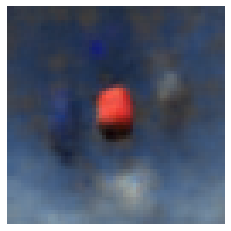

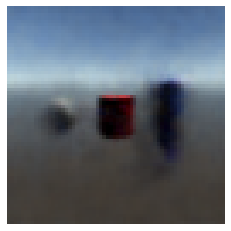

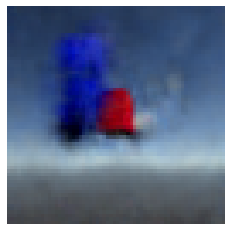

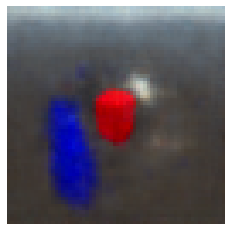

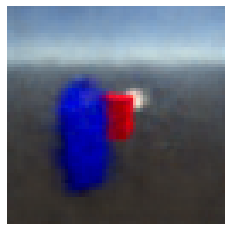

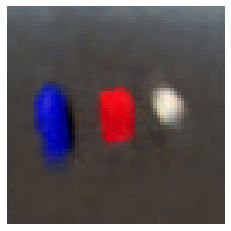

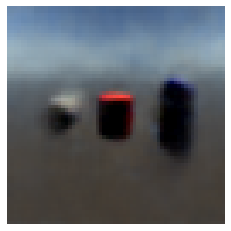

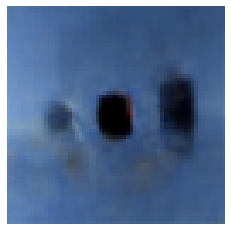

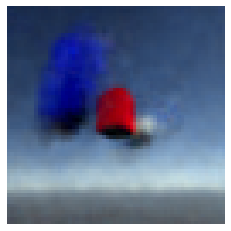

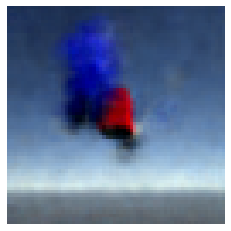

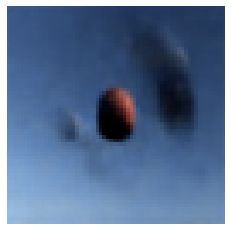

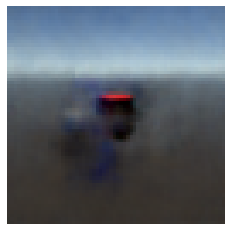

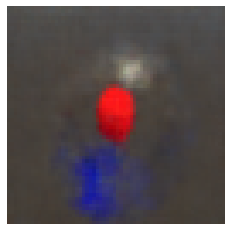

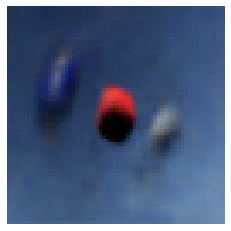

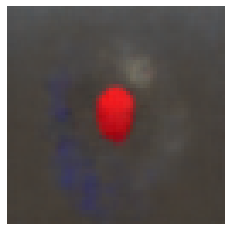

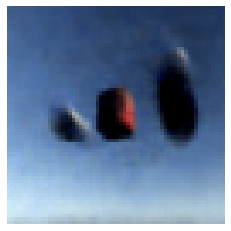

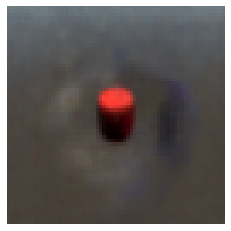

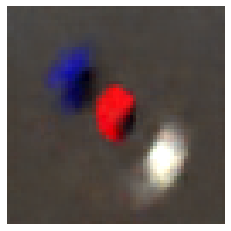

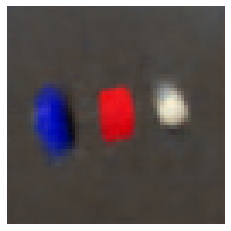

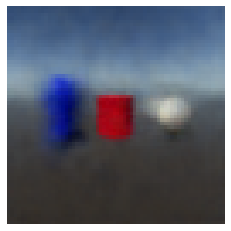

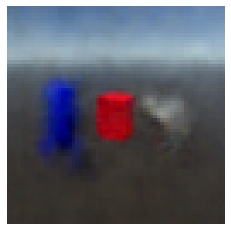

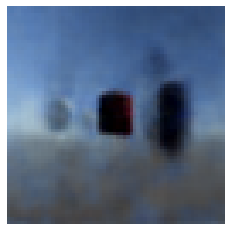

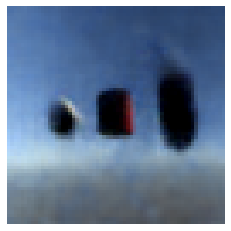

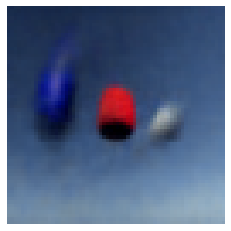

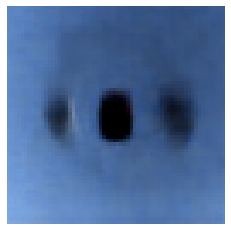

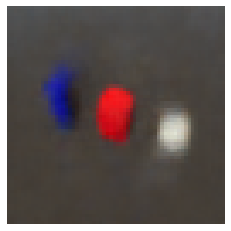

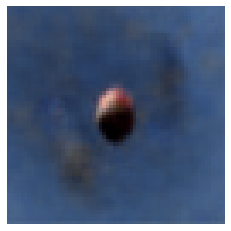

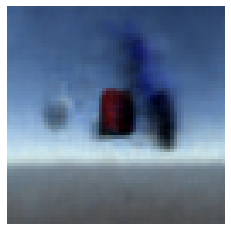

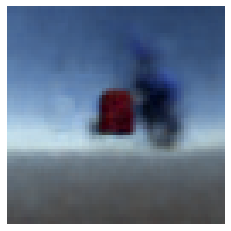

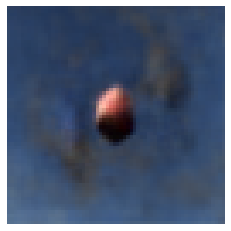

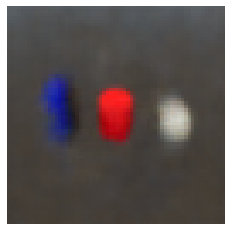

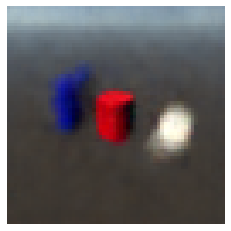

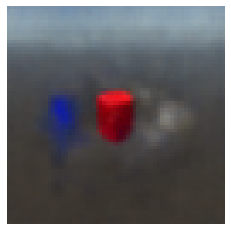

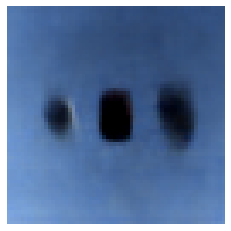

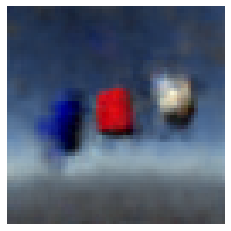

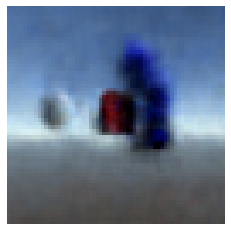

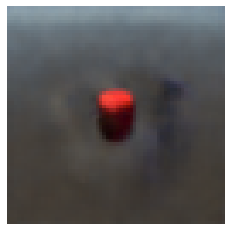

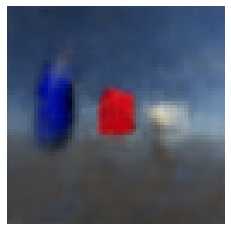

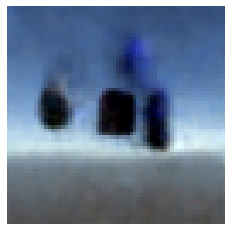

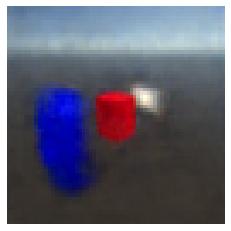

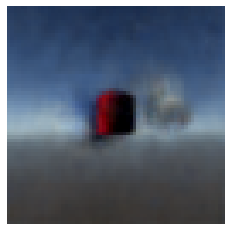

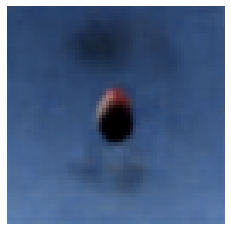

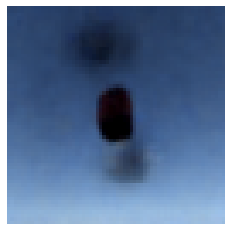

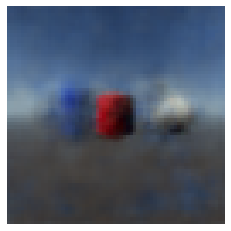

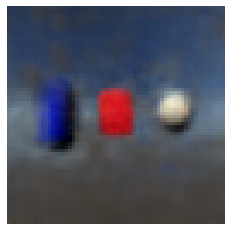

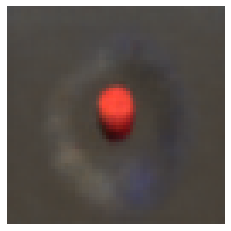

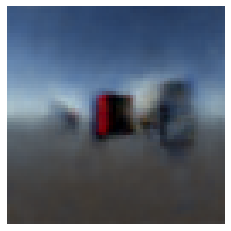

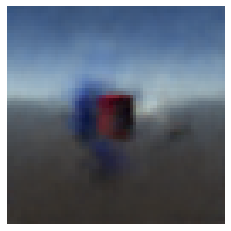

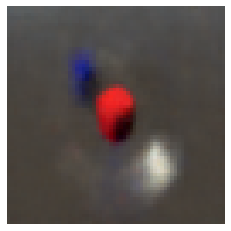

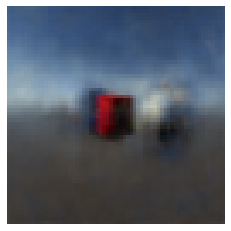

In [7]:
sampleImages = modelConvVAE.sample(50)
for im in sampleImages:
    im.visualize()

In [1]:
%load_ext autoreload
%autoreload 2

from repos.pyjunk.junktools import utils

utils.beep(800, 80, envelope=(10, 50, 0.1, 100))

In [23]:
import numpy as np

np.linspace(20, 10, 5)

array([20. , 17.5, 15. , 12.5, 10. ])

In [ ]:
import IPython

def beep(freq=440, msDuration=55.0, envelope=None):
    if(envelope != None):
        msAttack, msDecay, ratioSustain, msRelease = envelope

    fSampling = 44100
    npTime = np.linspace(start=0.0,
                         stop=(msDuration/1000.0),
                         num=int((msDuration/1000.0) * fSampling))

    # Release
    if(envelope != None):
        npTime = np.append(
            npTime,
            np.linspace(
                start=(msDuration/1000.0),
                stop=(msDuration/1000.0) + (msRelease / 1000.0),
                num=int((msRelease/1000.0) * fSampling))
        )

    npBeep = np.sin(npTime * freq * (2 * np.pi))

    # Envelope
    if(envelope != None):
        npAttack = np.linspace(start=0.0,
                               stop=1.0,
                               num=int((msAttack/1000.0) * fSampling))
        npDecay = np.linspace(start=1.0,
                              stop=ratioSustain,
                              num=int((msDecay / 1000.0) * fSampling))
        msSustain = msDuration - msDecay - msAttack
        npSustain = np.array([ratioSustain] * int((msSustain / 1000.0) * fSampling))
        npRelease = np.linspace(start=ratioSustain,
                                stop=0.0,
                                num=int((msRelease / 1000.0) * fSampling))
        npEnvelope = np.concatenate((npAttack, npDecay, npSustain, npRelease))

        npBeep = npBeep * npEnvelope

    return IPython.display.Audio(
        npBeep, rate=fSampling, autoplay=True)

beep(800, 80, envelope=(10, 50, 0.7, 1000))